In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing as mp
from collections import Counter
from sklearn.metrics import pairwise_distances_argmin_min
import timeit, time
import os
from scipy.stats import wilcoxon, fligner, ttest_ind, mannwhitneyu
from statsmodels.stats.multitest import multipletests
from statsmodels.api import qqplot
from tqdm import tqdm

pd.options.display.max_columns=None
pd.options.mode.chained_assignment=None
plt.rcParams['text.usetex'] = False

data_path = '/Users/mkamruz/Public/SNL/Projects/5UTR/Data/'

## Why chose 80% identity

In [2]:
def getStatesOfClusers(month, day, perc, lim=2):
    if lim<2: lim = 2

    data = pd.read_csv(os.path.join(data_path, f'output_{month}_{day}_{perc}.txt'), sep='\t', header=None)
    data.columns = ['ClsID','SeqID','Score','Status']
    data['seq_index'] = [int(x.split('|')[1]) for x in data.SeqID.values]
    #data = data[data.Status.isin(['C', 'M'])]
    
    tmp = data.groupby('ClsID')['seq_index'].apply(lambda x: x.nunique()).reset_index()
    res = [perc, tmp.ClsID.nunique(), tmp[tmp.seq_index<lim].ClsID.nunique(), tmp[tmp.seq_index>=lim].ClsID.nunique()]
    del [data, tmp]
    print(f"Clustering percentage={perc}, Total clusters={res[1]}, <{lim} clusters={res[2]}, >={lim} clusters={res[3]}")
    return res

In [3]:
m = 'Aug'
d = 26

lim = 2
res = []
for p in [40, 50, 62, 66, 67, 69, 72, 73, 80, 83, 84, 87, 88, 92, 94, 95, 96, 97]:
    res.append(getStatesOfClusers(m,d,p,lim))

df_cls_2 = pd.DataFrame(res, columns=['Perc', 'Total clusters', f'<{lim}', f'>={lim}'])
display(df_cls_2)
del [res]

print()

lim = 10
res = []
for p in [40, 50, 62, 66, 67, 69, 72, 73, 80, 83, 84, 87, 88, 92, 94, 95, 96, 97]:
    res.append(getStatesOfClusers(m,d,p,lim))

df_cls_10 = pd.DataFrame(res, columns=['Perc', 'Total clusters', f'<{lim}', f'>={lim}'])
display(df_cls_10)
del [res]

Clustering percentage=40, Total clusters=51521, <2 clusters=51520, >=2 clusters=1
Clustering percentage=50, Total clusters=517438, <2 clusters=517431, >=2 clusters=7
Clustering percentage=62, Total clusters=4869, <2 clusters=3353, >=2 clusters=1516
Clustering percentage=66, Total clusters=3186, <2 clusters=401, >=2 clusters=2785
Clustering percentage=67, Total clusters=4810, <2 clusters=1034, >=2 clusters=3776
Clustering percentage=69, Total clusters=8989, <2 clusters=3129, >=2 clusters=5860
Clustering percentage=72, Total clusters=10567, <2 clusters=4137, >=2 clusters=6430
Clustering percentage=73, Total clusters=11413, <2 clusters=4314, >=2 clusters=7099
Clustering percentage=80, Total clusters=79797, <2 clusters=47965, >=2 clusters=31832
Clustering percentage=83, Total clusters=135231, <2 clusters=94159, >=2 clusters=41072
Clustering percentage=84, Total clusters=277822, <2 clusters=232115, >=2 clusters=45707
Clustering percentage=87, Total clusters=868869, <2 clusters=802973, >=2 c

,Perc,Total clusters,<2,>=2
0,40,51521,51520,1
1,50,517438,517431,7
2,62,4869,3353,1516
3,66,3186,401,2785
4,67,4810,1034,3776
5,69,8989,3129,5860
6,72,10567,4137,6430
7,73,11413,4314,7099
8,80,79797,47965,31832
9,83,135231,94159,41072



Clustering percentage=40, Total clusters=51521, <10 clusters=51520, >=10 clusters=1
Clustering percentage=50, Total clusters=517438, <10 clusters=517431, >=10 clusters=7
Clustering percentage=62, Total clusters=4869, <10 clusters=3353, >=10 clusters=1516
Clustering percentage=66, Total clusters=3186, <10 clusters=403, >=10 clusters=2783
Clustering percentage=67, Total clusters=4810, <10 clusters=1039, >=10 clusters=3771
Clustering percentage=69, Total clusters=8989, <10 clusters=3142, >=10 clusters=5847
Clustering percentage=72, Total clusters=10567, <10 clusters=4148, >=10 clusters=6419
Clustering percentage=73, Total clusters=11413, <10 clusters=4322, >=10 clusters=7091
Clustering percentage=80, Total clusters=79797, <10 clusters=48115, >=10 clusters=31682
Clustering percentage=83, Total clusters=135231, <10 clusters=94613, >=10 clusters=40618
Clustering percentage=84, Total clusters=277822, <10 clusters=232568, >=10 clusters=45254
Clustering percentage=87, Total clusters=868869, <1

,Perc,Total clusters,<10,>=10
0,40,51521,51520,1
1,50,517438,517431,7
2,62,4869,3353,1516
3,66,3186,403,2783
4,67,4810,1039,3771
5,69,8989,3142,5847
6,72,10567,4148,6419
7,73,11413,4322,7091
8,80,79797,48115,31682
9,83,135231,94613,40618


In [5]:
lim = 2
df_cls_2[f'Perc_<{lim}'] = np.round(df_cls_2[f'<{lim}']*100/df_cls_2['Total clusters'], 3)
df_cls_2[f'Perc_>={lim}'] = [100 - x for x in df_cls_2[f'Perc_<{lim}']]
df_cls_2.sort_values('Perc', inplace=True)
display(df_cls_2.head())

,Perc,Total clusters,<2,>=2,Perc_<2,Perc_>=2
0,40,51521,51520,1,99.998,0.002
1,50,517438,517431,7,99.999,0.001
2,62,4869,3353,1516,68.864,31.136
3,66,3186,401,2785,12.586,87.414
4,67,4810,1034,3776,21.497,78.503


In [6]:
lim = 10
df_cls_10[f'Perc_<{lim}'] = np.round(df_cls_10[f'<{lim}']*100/df_cls_10['Total clusters'], 3)
df_cls_10[f'Perc_>={lim}'] = [100 - x for x in df_cls_10[f'Perc_<{lim}']]
df_cls_10.sort_values('Perc', inplace=True)
display(df_cls_10.head())

,Perc,Total clusters,<10,>=10,Perc_<10,Perc_>=10
0,40,51521,51520,1,99.998,0.002
1,50,517438,517431,7,99.999,0.001
2,62,4869,3353,1516,68.864,31.136
3,66,3186,403,2783,12.649,87.351
4,67,4810,1039,3771,21.601,78.399


## 1) Graph the number of clusters generated for each choice of % identity.  The attached graph is linear Y-scale, & includes both singleton & non-singleton clusters.  This is valuable, but I'd also try graphing with log10 Y-scale, & versions in which only clusters of >=10 members are graphed.  This will help with reporting the % identity threshold we decide upon & what it means for the number & size of our clusters.

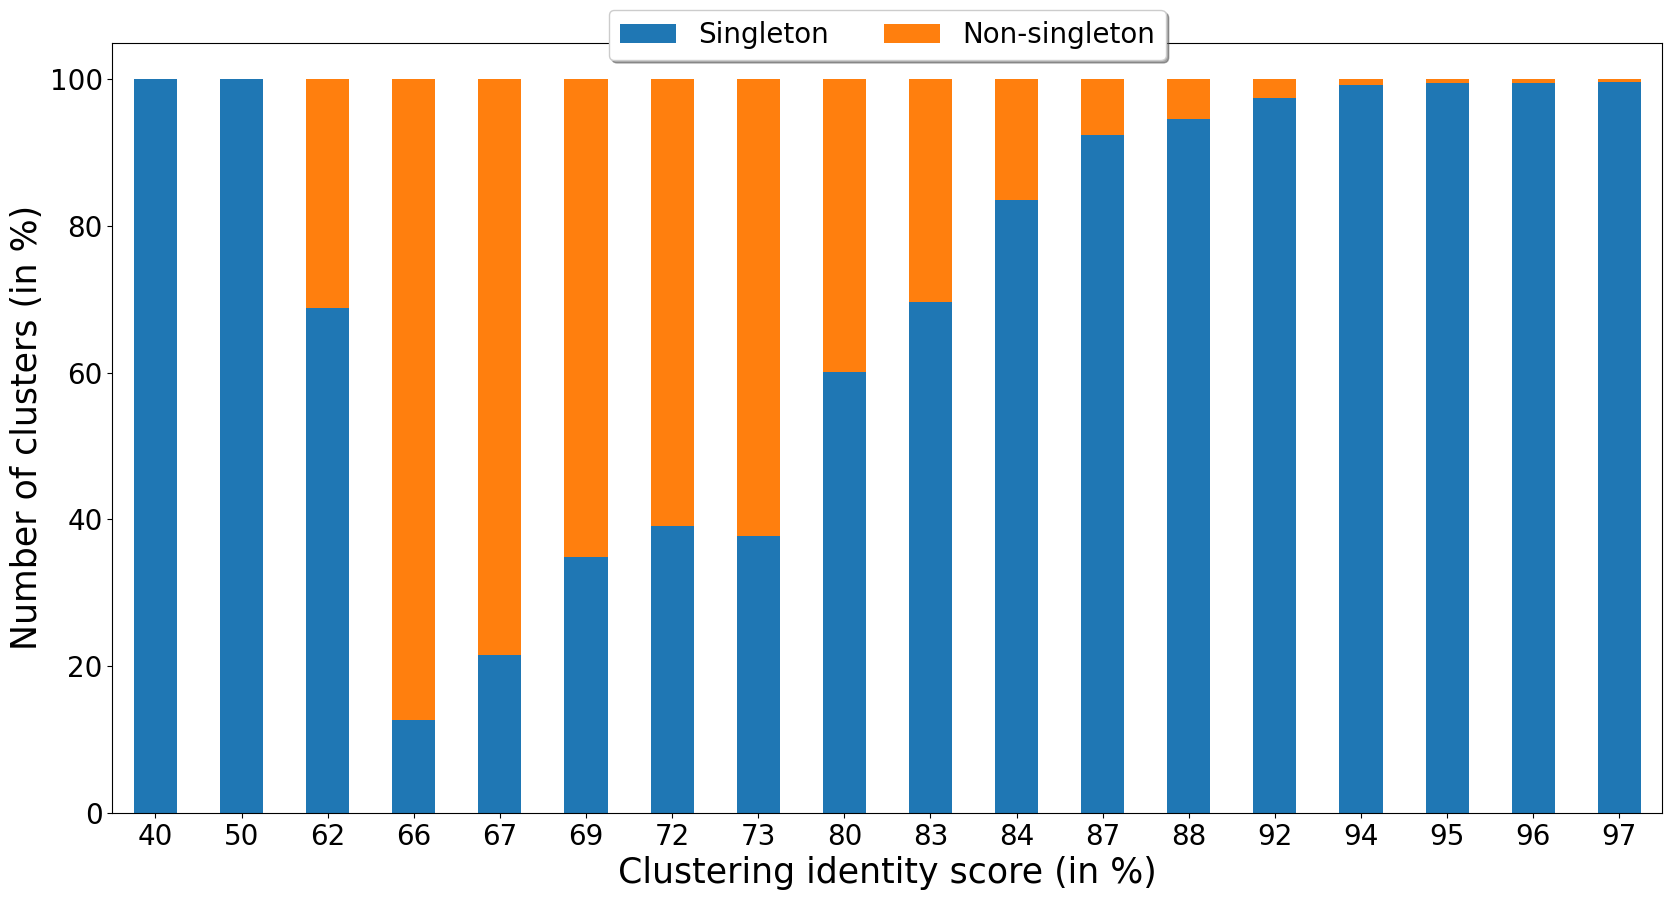

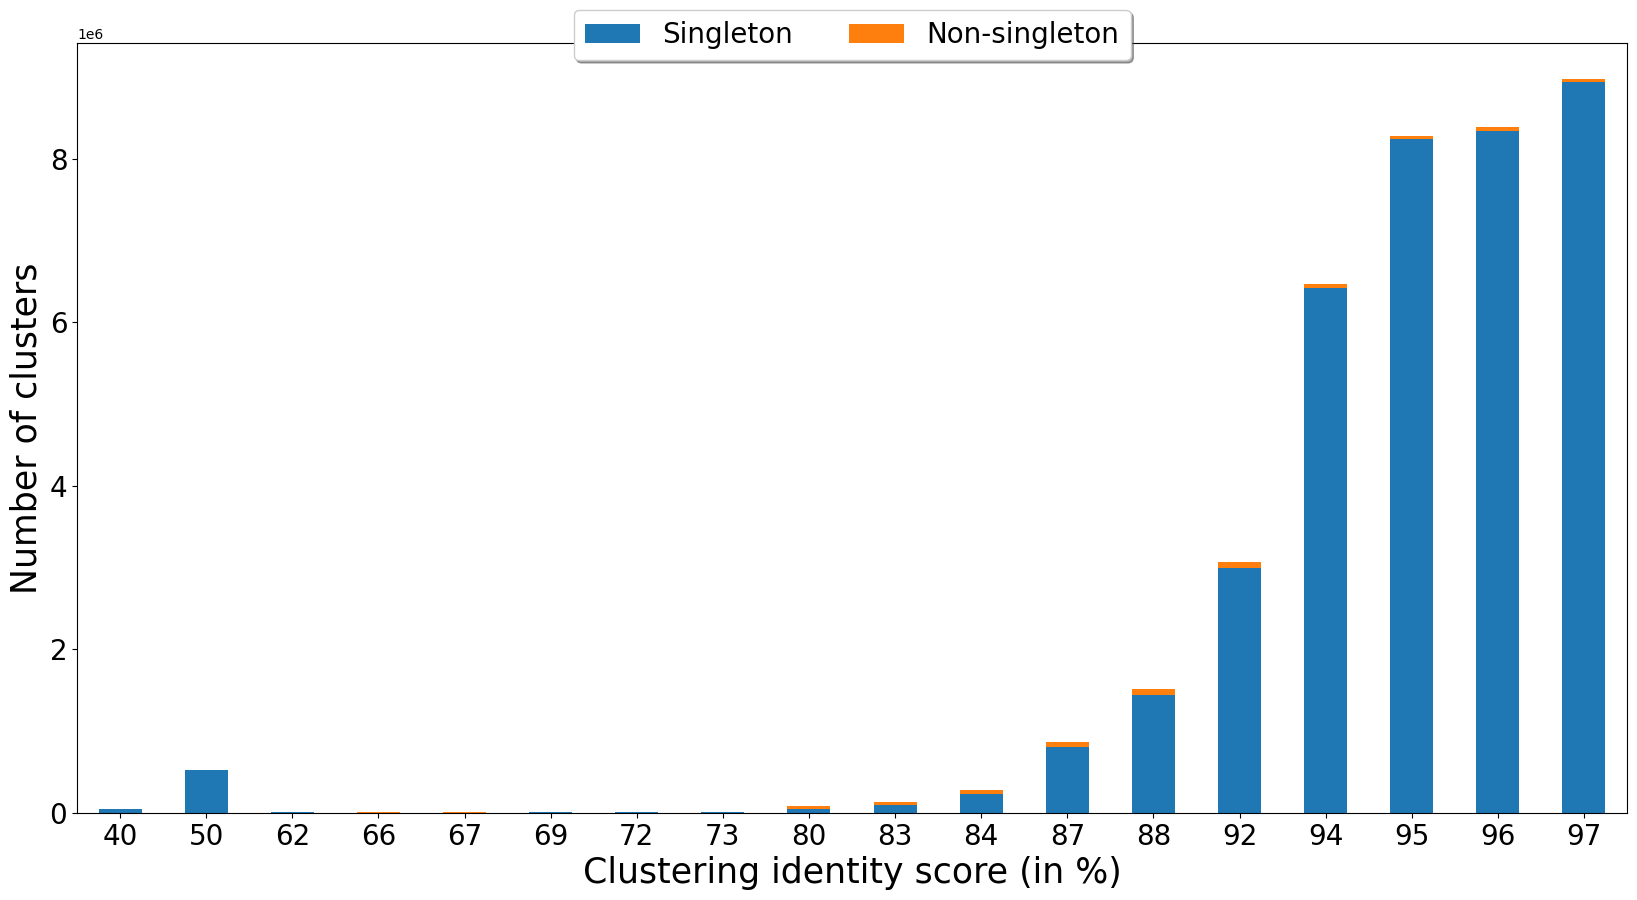

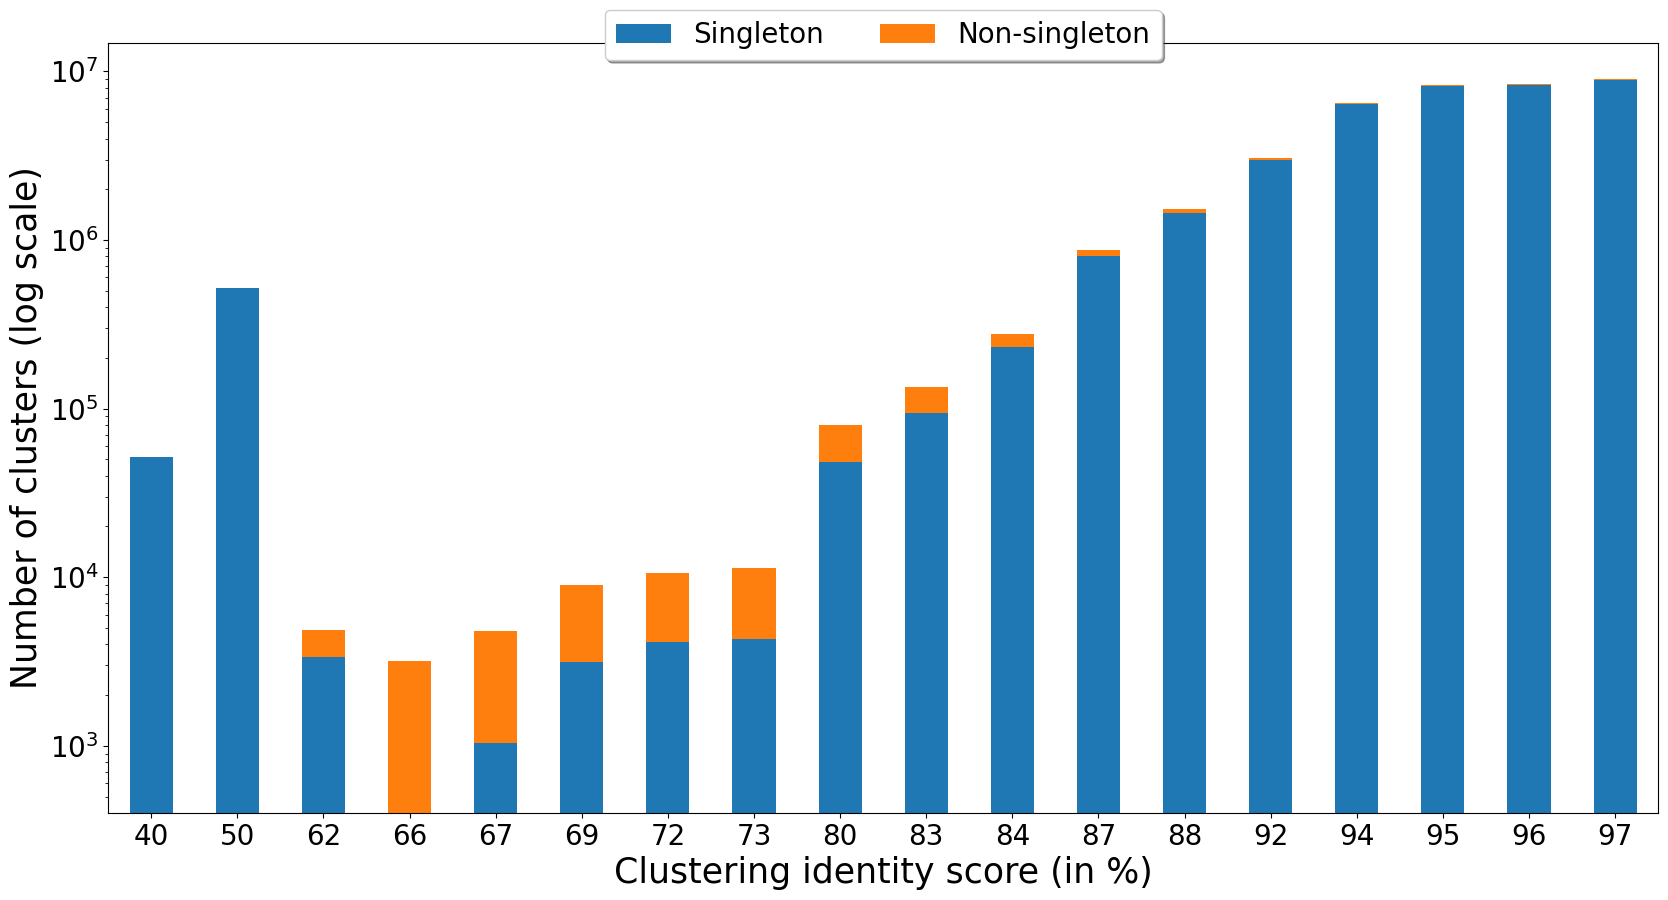

In [21]:
lim = 2
tmp = df_cls_2[['Perc', f'Perc_<{lim}', f'Perc_>={lim}']]
tmp.rename(columns={f'Perc_<{lim}': 'Singleton', f'Perc_>={lim}': 'Non-singleton'}, inplace=True)

tmp.plot(x='Perc', y=['Singleton', 'Non-singleton'], logy=False, kind='bar', figsize=(20,10), fontsize=20, rot=0, stacked=True, mark_right=True)
plt.ylabel('Number of clusters (in %)', fontsize=25)
plt.xlabel('Clustering identity score (in %)', fontsize=25)
plt.legend(fontsize=20, bbox_to_anchor=(0.5, 1.01), loc='center', ncol=2, fancybox=True, shadow=True)
plt.show()

lim = 2
tmp = df_cls_2[['Perc', f'<{lim}', f'>={lim}']]
tmp.rename(columns={f'<{lim}': 'Singleton', f'>={lim}': 'Non-singleton'}, inplace=True)

tmp.plot(x='Perc', y=['Singleton', 'Non-singleton'], logy=False, kind='bar', figsize=(20,10), fontsize=20, rot=0, stacked=True, mark_right=True)
plt.ylabel('Number of clusters', fontsize=25)
plt.xlabel('Clustering identity score (in %)', fontsize=25)
plt.legend(fontsize=20, bbox_to_anchor=(0.5, 1.01), loc='center', ncol=2, fancybox=True, shadow=True)
plt.show()

tmp.plot(x='Perc', y=['Singleton', 'Non-singleton'], logy=True, kind='bar', figsize=(20,10), fontsize=20, rot=0, stacked=True, mark_right=True)
plt.ylabel('Number of clusters (log scale)', fontsize=25)
plt.xlabel('Clustering identity score (in %)', fontsize=25)
plt.legend(fontsize=20, bbox_to_anchor=(0.5, 1.01), loc='center', ncol=2, fancybox=True, shadow=True)
plt.show()

In [24]:
lim=2
tmp1 = df_cls_2[['Perc', f'Perc_<{lim}', f'Perc_>={lim}', f'<{lim}', f'>={lim}']]
lim=10
tmp2 = df_cls_10[['Perc', f'Perc_<{lim}', f'Perc_>={lim}', f'<{lim}', f'>={lim}']]

tmp = tmp1.merge(tmp2, on='Perc')
tmp = tmp[['Perc', '<2', '<10', '>=2', '>=10', 'Perc_<2', 'Perc_<10', 'Perc_>=2', 'Perc_>=10']]
del [tmp1, tmp2]
print(tmp.shape)
print(tmp.columns)
tmp.head(20)

(18, 9)
Index(['Perc', '<2', '<10', '>=2', '>=10', 'Perc_<2', 'Perc_<10', 'Perc_>=2',
       'Perc_>=10'],
      dtype='object')


,Perc,<2,<10,>=2,>=10,Perc_<2,Perc_<10,Perc_>=2,Perc_>=10
0,40,51520,51520,1,1,99.998,99.998,0.002,0.002
1,50,517431,517431,7,7,99.999,99.999,0.001,0.001
2,62,3353,3353,1516,1516,68.864,68.864,31.136,31.136
3,66,401,403,2785,2783,12.586,12.649,87.414,87.351
4,67,1034,1039,3776,3771,21.497,21.601,78.503,78.399
5,69,3129,3142,5860,5847,34.809,34.954,65.191,65.046
6,72,4137,4148,6430,6419,39.150,39.254,60.850,60.746
7,73,4314,4322,7099,7091,37.799,37.869,62.201,62.131
8,80,47965,48115,31832,31682,60.109,60.297,39.891,39.703
9,83,94159,94613,41072,40618,69.628,69.964,30.372,30.036


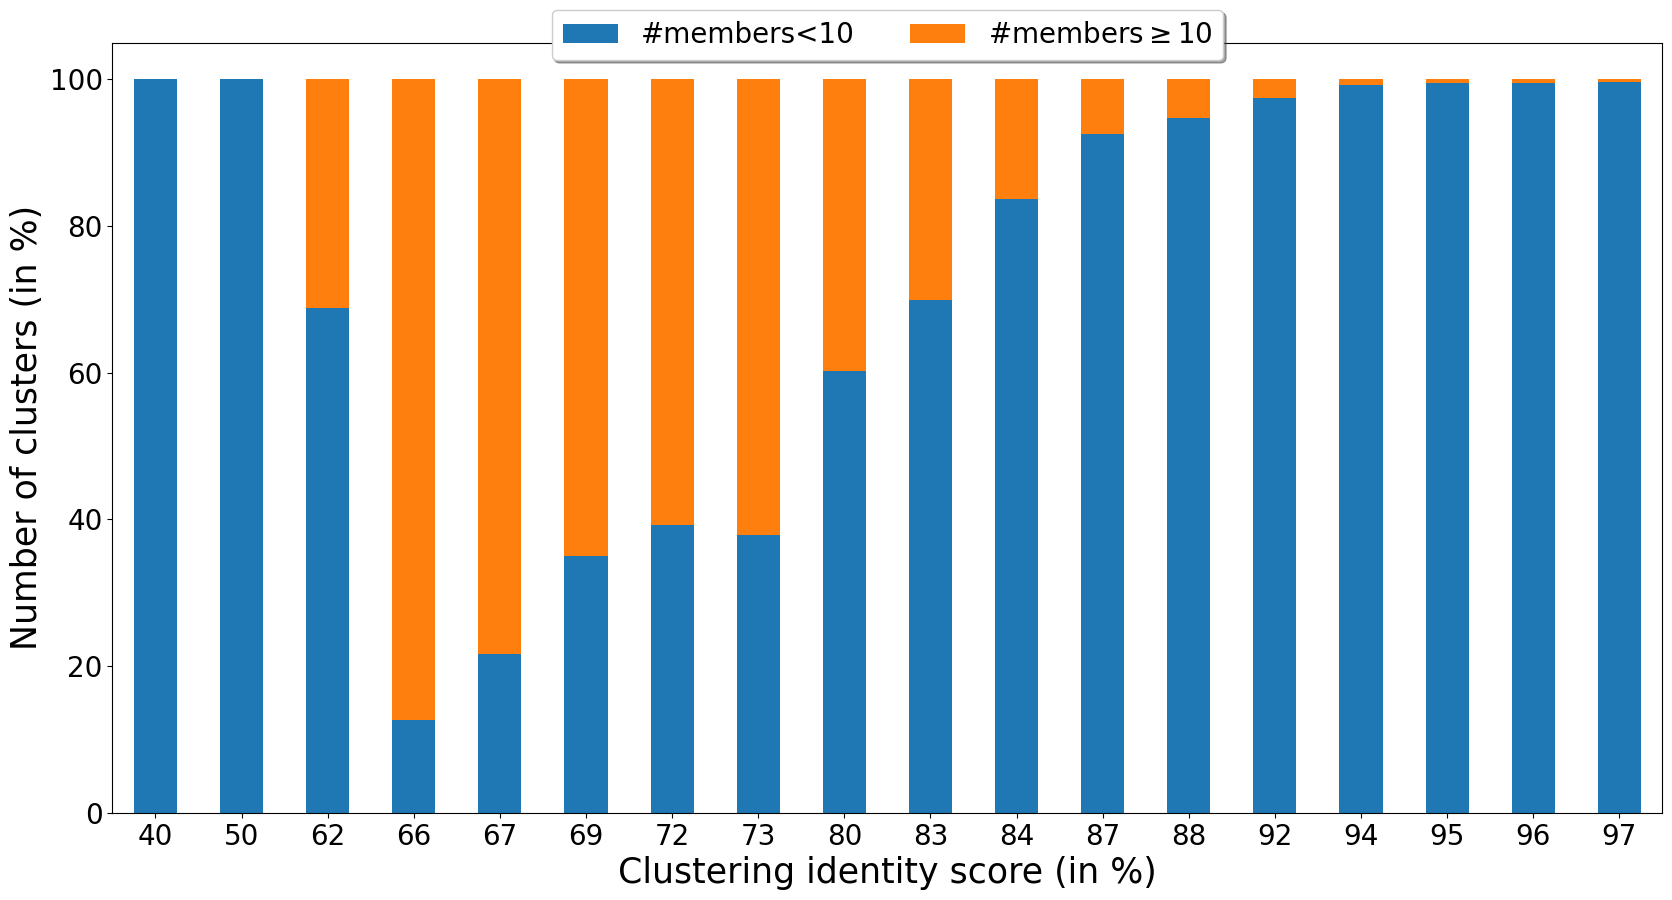

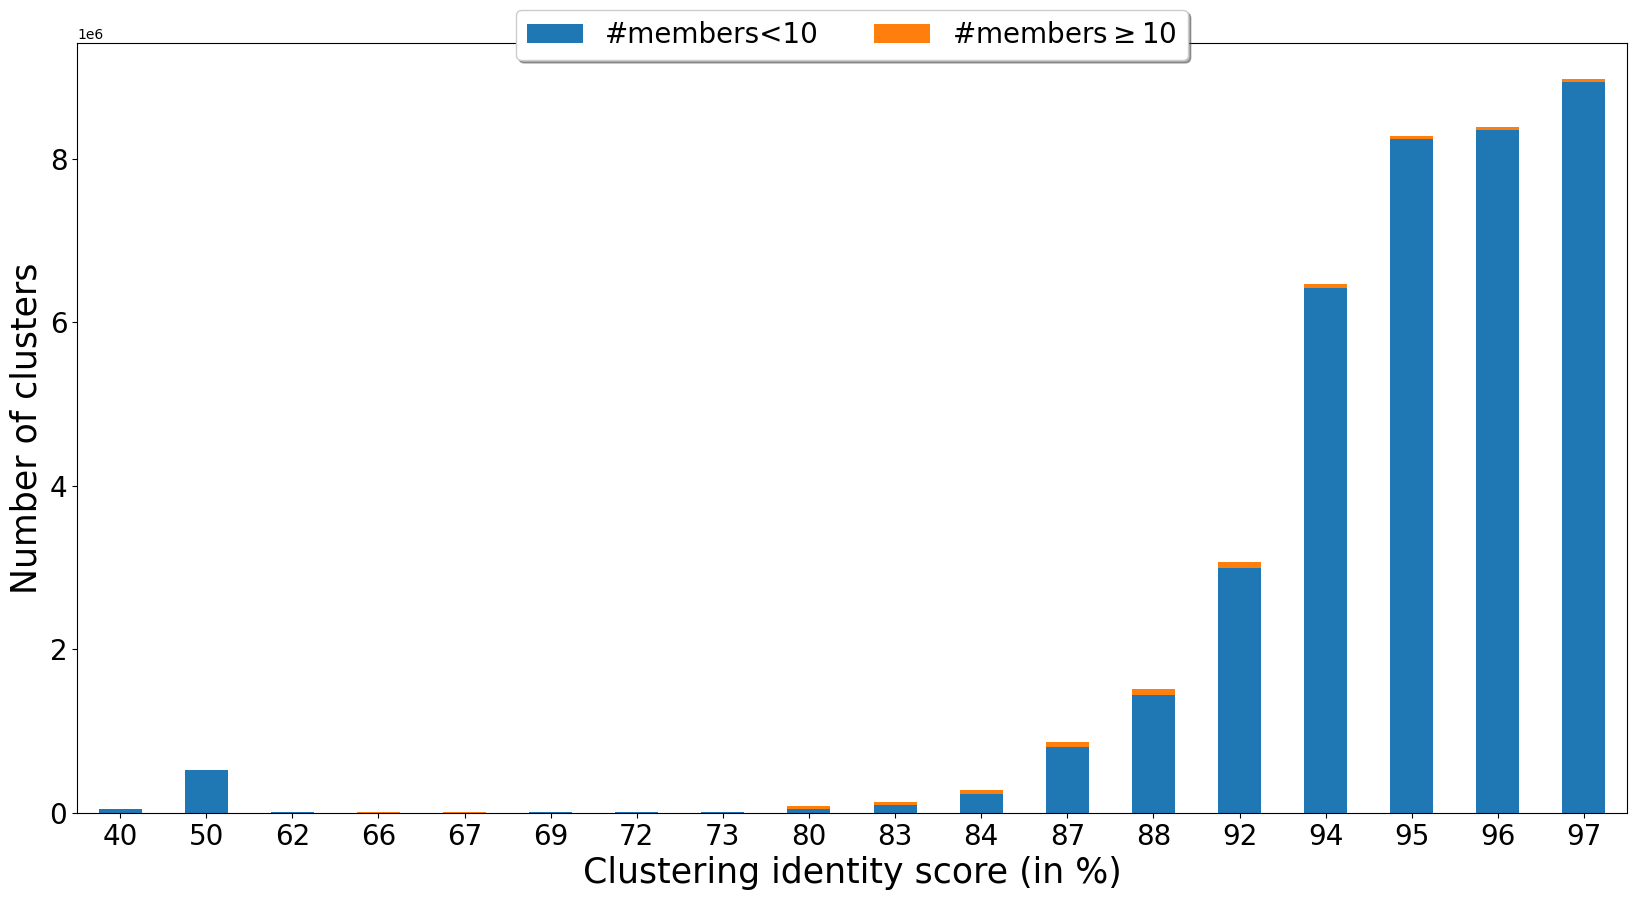

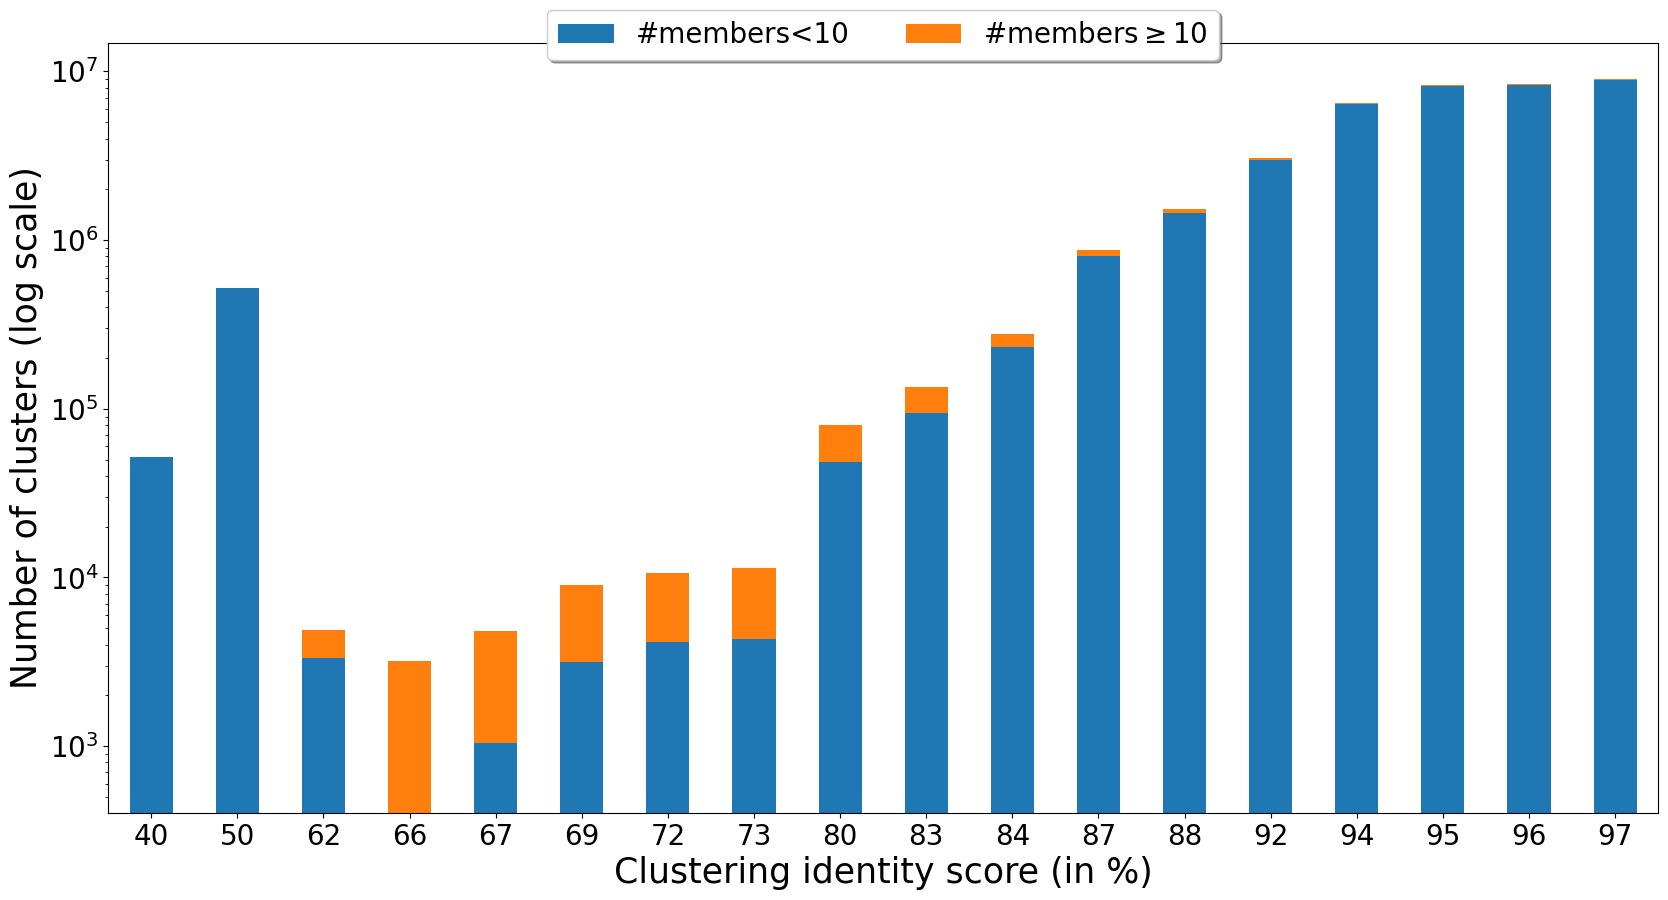

In [22]:
lim = 10
tmp = df_cls_10[['Perc', f'Perc_<{lim}', f'Perc_>={lim}']]
tmp.rename(columns={f'Perc_<{lim}': f'#members<{lim}', f'Perc_>={lim}': f'#members$\\geq${lim}'}, inplace=True)

tmp.plot(x='Perc', y=[f'#members<{lim}', f'#members$\\geq${lim}'], logy=False, kind='bar', figsize=(20,10), fontsize=20, rot=0, stacked=True, mark_right=True)
plt.ylabel('Number of clusters (in %)', fontsize=25)
plt.xlabel('Clustering identity score (in %)', fontsize=25)
plt.legend(fontsize=20, bbox_to_anchor=(0.5, 1.01), loc='center', ncol=2, fancybox=True, shadow=True)
plt.show()

lim = 10
tmp = df_cls_10[['Perc', f'<{lim}', f'>={lim}']]
tmp.rename(columns={f'<{lim}': f'#members<{lim}', f'>={lim}': f'#members$\\geq${lim}'}, inplace=True)

tmp.plot(x='Perc', y=[f'#members<{lim}', f'#members$\\geq${lim}'], logy=False, kind='bar', figsize=(20,10), fontsize=20, rot=0, stacked=True, mark_right=True)
plt.ylabel('Number of clusters', fontsize=25)
plt.xlabel('Clustering identity score (in %)', fontsize=25)
plt.legend(fontsize=20, bbox_to_anchor=(0.5, 1.01), loc='center', ncol=2, fancybox=True, shadow=True)
plt.show()

tmp.plot(x='Perc', y=[f'#members<{lim}', f'#members$\\geq${lim}'], logy=True, kind='bar', figsize=(20,10), fontsize=20, rot=0, stacked=True, mark_right=True)
plt.ylabel('Number of clusters (log scale)', fontsize=25)
plt.xlabel('Clustering identity score (in %)', fontsize=25)
plt.legend(fontsize=20, bbox_to_anchor=(0.5, 1.01), loc='center', ncol=2, fancybox=True, shadow=True)
plt.show()

## 2) Decide upon that threshold, & then list out the clusters & their member sequences so that we can look for patterns in them (eg, using STREME).  I've attached a Word doc with text from a previous Teams chat in which you described this process.  A threshold of 80% identity was selected, & then you computed the mean prediction score for each cluster & generated low-score & high-score bins accordingly.  In this case, you're clustering sequences that were already binned.  However, I think it'd be valuable to compute the mean prediction score for each cluster within a given bin so that we can focus on those at the extremes (ie, the lowest-scoring clusters, & the highest-scoring clusters).

In [2]:
def compute_prection_scores(df):
    tmp = df.drop(columns=['sequence','DNABERT2_cao2021', 'grover_cao2021', 'utrlm_cao2021'])
    v = tmp.sum(axis=1).values.tolist()
    del tmp
    return v

def compute_gc_content(sequences):
    def gc(seq):
        gc_count = seq.count('G') + seq.count('C')
        return gc_count / len(seq) if len(seq) > 0 else 0
    
    return [gc(seq) for seq in sequences]

df = pd.read_csv(os.path.join(data_path, 'combined_results.csv'))
df['prediction_score'] = compute_prection_scores(df)
df['prediction_score'] = df['prediction_score'].astype(int)
df['gc_content'] = compute_gc_content(df['sequence'])
df = df[['sequence', 'gc_content', 'prediction_score']].drop_duplicates()
print(df.shape)
#df.to_csv(os.path.join(data_path, 'gc_content_predictions_no_cao2021.csv'), index=False)
df.head()

(10000000, 3)


,sequence,gc_content,prediction_score
0,GTTCTATAGACATGAATGATTTGCG,0.36,15
1,CATTGACTAGCCCCATCCAATTGTA,0.44,18
2,CAGGCCTGTGGACGGCAAGTCTAGT,0.60,18
3,AGTTCAGACGCTATCTCTCACGATT,0.44,20
4,CGAAAGGTTGCGATCTCAGTTGTGC,0.52,20


In [4]:
fn = ['output_Aug_26_80', 'output_Sept_80_0_10', 'output_Sept_80_0_11', 'output_Sept_80_23_24']
fi = 0
data = pd.read_csv(os.path.join(data_path, f'{fn[fi]}.txt'), sep='\t', header=None)
data.columns = ['ClsID','SeqID','Score','Status']
data['seq_index'] = [int(x.split('|')[1]) for x in data.SeqID.values]
data['prediction_score'] = [int(x.split('|')[2]) for x in data.SeqID.values]

print(data.shape)
print(data.prediction_score.min(), data.prediction_score.max())
display(data.head())

(10000000, 6)
2 27


,ClsID,SeqID,Score,Status,seq_index,prediction_score
0,1,>gi|146|20|44.00,0.9726,C,146,20
1,1,>gi|206|20|40.00,0.8269,M,206,20
2,1,>gi|276|22|48.00,0.8465,M,276,22
3,1,>gi|322|23|44.00,0.8250,M,322,23
4,1,>gi|400|19|48.00,0.8533,M,400,19


In [9]:
tmp = data.groupby('ClsID')['seq_index'].apply(lambda x: x.nunique()).reset_index()
tmp.columns = ['ClsID', 'size']
print(tmp[tmp['size']<10].ClsID.nunique())
print(tmp[tmp['size']>=10].ClsID.nunique())
tmp.head()

48115
31682


,ClsID,size
0,1,44695
1,2,4625
2,3,40075
3,4,19001
4,5,1816


In [78]:
df = pd.read_csv(os.path.join(data_path, "random_25mers_10M.csv"))
df.columns = ['sequence', 'seq_index']
tmp = pd.read_csv(os.path.join(data_path, 'gc_content_predictions_no_cao2021.csv'))
tmp.prediction_score = tmp.prediction_score.astype(int)
df = df.merge(tmp, on='sequence')
print(df.shape)
print(df['prediction_score'].min(), df['prediction_score'].max())
df.head()

(10000000, 4)
0 24


,sequence,seq_index,gc_content,prediction_score
0,GTTCTATAGACATGAATGATTTGCG,0,0.36,15
1,CATTGACTAGCCCCATCCAATTGTA,1,0.44,18
2,CAGGCCTGTGGACGGCAAGTCTAGT,2,0.60,18
3,AGTTCAGACGCTATCTCTCACGATT,3,0.44,20
4,CGAAAGGTTGCGATCTCAGTTGTGC,4,0.52,20


In [80]:
df[df.seq_index==31297-1]

,sequence,seq_index,gc_content,prediction_score
31296,GGTGCCCCTGATGGCGCCAGCGGGT,31296,0.76,8


### Generate combined results

In [3]:
fn = ['output_Aug_26_80', 'output_Sept_80_0_10', 'output_Sept_80_0_11', 'output_Sept_80_23_24']
fi = 0
data = pd.read_csv(os.path.join(data_path, f'{fn[fi]}.txt'), sep='\t', header=None)
data.columns = ['ClsID','SeqID','Score','Status']
if fi==0:
    data['seq_index'] = [int(x.split('|')[1]) for x in data.SeqID.values]
else:
    data['seq_index'] = [int(x.split('|')[1])-1 for x in data.SeqID.values]
data['prediction_score'] = [int(x.split('|')[2]) for x in data.SeqID.values]

print(data.shape)
print(data.prediction_score.min(), data.prediction_score.max())
display(data.head())

if fi==0:
    data = data[['ClsID', 'seq_index']]
else:
    data = data[['ClsID', 'seq_index', 'prediction_score']]

df = pd.read_csv(os.path.join(data_path, "random_25mers_10M.csv"))
df.columns = ['sequence', 'seq_index']

data = data.merge(df, on='seq_index')
print(data.shape)
del[df]

df = pd.read_csv(os.path.join(data_path, 'gc_content_predictions_no_cao2021.csv'))
df.prediction_score = df.prediction_score.astype(int)
print(df.prediction_score.min(), df.prediction_score.max())
if fi==0:
    data = data.merge(df, on='sequence')
else:
    data = data.merge(df, on=['sequence', 'prediction_score'])
print(data.shape, df.shape)
del [df]

#data.to_csv(os.path.join(data_path, 'gc_content_predictions_clsID_noc_80_23_24.csv'), index=False)
print(data.prediction_score.min(), data.prediction_score.max())
data.head()

(10000000, 6)
2 27


,ClsID,SeqID,Score,Status,seq_index,prediction_score
0,1,>gi|146|20|44.00,0.9726,C,146,20
1,1,>gi|206|20|40.00,0.8269,M,206,20
2,1,>gi|276|22|48.00,0.8465,M,276,22
3,1,>gi|322|23|44.00,0.8250,M,322,23
4,1,>gi|400|19|48.00,0.8533,M,400,19


(10000000, 3)
0 24
(10000000, 5) (10000000, 3)
0 24


,ClsID,seq_index,sequence,gc_content,prediction_score
0,1,146,ACCCATGTCTGGCGAAAGTTATACA,0.44,17
1,1,206,CTAAGTCCACGGTGGATATTACAAA,0.40,18
2,1,276,GACCTACCAAGCGTAAGGTATTCTG,0.48,20
3,1,322,TGTGTTCCTACCGAATACGCAGTAT,0.44,21
4,1,400,CCGGTTATTCAAACTAGATCGTGCC,0.48,18


In [4]:
data.prediction_score.min(), data.prediction_score.max(), data.ClsID.min(), data.ClsID.max()

(np.int64(0), np.int64(24), np.int64(1), np.int64(79797))

### Use the generated data to move forward

In [99]:
lim = 10
fn = ['gc_content_predictions_clsID_no_cao2021', 'gc_content_predictions_clsID_noc_80_0_10', 'gc_content_predictions_clsID_noc_80_0_11', 'gc_content_predictions_clsID_noc_80_23_24']
i = 0
print(f"Processing {fn[i]}.csv file")
data = pd.read_csv(os.path.join(data_path, f"{fn[i]}.csv"))
print(data.shape)
print(data.prediction_score.min(), data.prediction_score.max())
display(data.head())
df_count = data.groupby('ClsID')['sequence'].apply(lambda x: x.nunique()).reset_index()
df_count.columns = ['ClsID', 'member_count']
print(df_count.ClsID.nunique(), df_count[df_count.member_count<lim].ClsID.nunique(), df_count[df_count.member_count>=lim].ClsID.nunique())
display(df_count.head())

Processing gc_content_predictions_clsID_no_cao2021.csv file
(10000000, 5)
0 24


,ClsID,seq_index,sequence,gc_content,prediction_score
0,1,146,ACCCATGTCTGGCGAAAGTTATACA,0.44,17
1,1,206,CTAAGTCCACGGTGGATATTACAAA,0.40,18
2,1,276,GACCTACCAAGCGTAAGGTATTCTG,0.48,20
3,1,322,TGTGTTCCTACCGAATACGCAGTAT,0.44,21
4,1,400,CCGGTTATTCAAACTAGATCGTGCC,0.48,18


79797 48115 31682


,ClsID,member_count
0,1,44695
1,2,4625
2,3,40075
3,4,19001
4,5,1816


In [100]:
tmp = data[data.ClsID.isin(df_count[df_count.member_count>=lim].ClsID.unique())].groupby('ClsID')['sequence'].apply(lambda x: x.nunique()).reset_index()
tmp.sort_values('sequence', ascending=False, inplace=True)
print(sorted(tmp.ClsID[:20].values.tolist()))

clsIDs = sorted(list(set(df_count[df_count.member_count>=lim].ClsID.unique()).intersection(set(tmp.ClsID[:20].values.tolist()))))
print(clsIDs)

df = data.loc[data.ClsID.isin(clsIDs), ['ClsID','sequence','prediction_score']]
print(df.shape, df.drop_duplicates().shape)
#df.to_csv(os.path.join(data_path, 'Top_20_clusters_seq_High_23_24.csv'), index=False)
print(df.prediction_score.min(), df.prediction_score.max())

[1, 3, 4, 6, 7, 9, 10, 13, 16, 53, 67, 80, 123, 164, 280, 681, 695, 739, 753, 6568]
[1, 3, 4, 6, 7, 9, 10, 13, 16, 53, 67, 80, 123, 164, 280, 681, 695, 739, 753, 6568]
(303421, 3) (303421, 3)
3 24


In [101]:
tmp1 = data[data.ClsID.isin(df_count[df_count.member_count>=1].ClsID.unique())].groupby('prediction_score')['ClsID'].apply(lambda x: x.nunique()).reset_index()
tmp1.columns = ['prediction_score', 'Total clusters>=1']
print(data[data.ClsID.isin(df_count[df_count.member_count>=1].ClsID.unique())].ClsID.nunique())

tmp2 = data[data.ClsID.isin(df_count[df_count.member_count>=10].ClsID.unique())].groupby('prediction_score')['ClsID'].apply(lambda x: x.nunique()).reset_index()
tmp2.columns = ['prediction_score', 'Total clusters>=10']
print(data[data.ClsID.isin(df_count[df_count.member_count>=10].ClsID.unique())].ClsID.nunique())

tmp3 = data[data.ClsID.isin(df_count[df_count.member_count<10].ClsID.unique())].groupby('prediction_score')['ClsID'].apply(lambda x: x.nunique()).reset_index()
tmp3.columns = ['prediction_score', 'Total clusters<10']
print(data[data.ClsID.isin(df_count[df_count.member_count<10].ClsID.unique())].ClsID.nunique())

tmp = tmp1.merge(tmp2, on='prediction_score', how='left')
tmp = tmp.merge(tmp3, on='prediction_score', how='left')
tmp['Total clusters<10'] = tmp['Total clusters<10'].fillna(0)
tmp['Total clusters<10'] = tmp['Total clusters<10'].astype(int)
#tmp['diff'] = [np.absolute(x-y) for x,y in zip(tmp['Total clusters>=1'].values, tmp['Total clusters>=10'].values)]
#tmp['perc_diff'] = [100*np.absolute(x-y)/x for x,y in zip(tmp['Total clusters>=1'].values, tmp['Total clusters>=10'].values)]
del[tmp1, tmp2, tmp3]
tmp

79797
31682
48115


,prediction_score,Total clusters>=1,Total clusters>=10,Total clusters<10
0,0,2,2,0
1,1,2,2,0
2,2,28,27,1
3,3,137,133,4
4,4,417,406,11
5,5,1133,1116,17
6,6,2541,2491,50
7,7,5026,4906,120
8,8,8414,8193,221
9,9,12895,12528,367


10


,prediction_score,Total clusters
0,0,2
1,1,2
2,2,27
3,3,133
4,4,406
5,5,1116
6,6,2491
7,7,4906
8,8,8193
9,9,12528


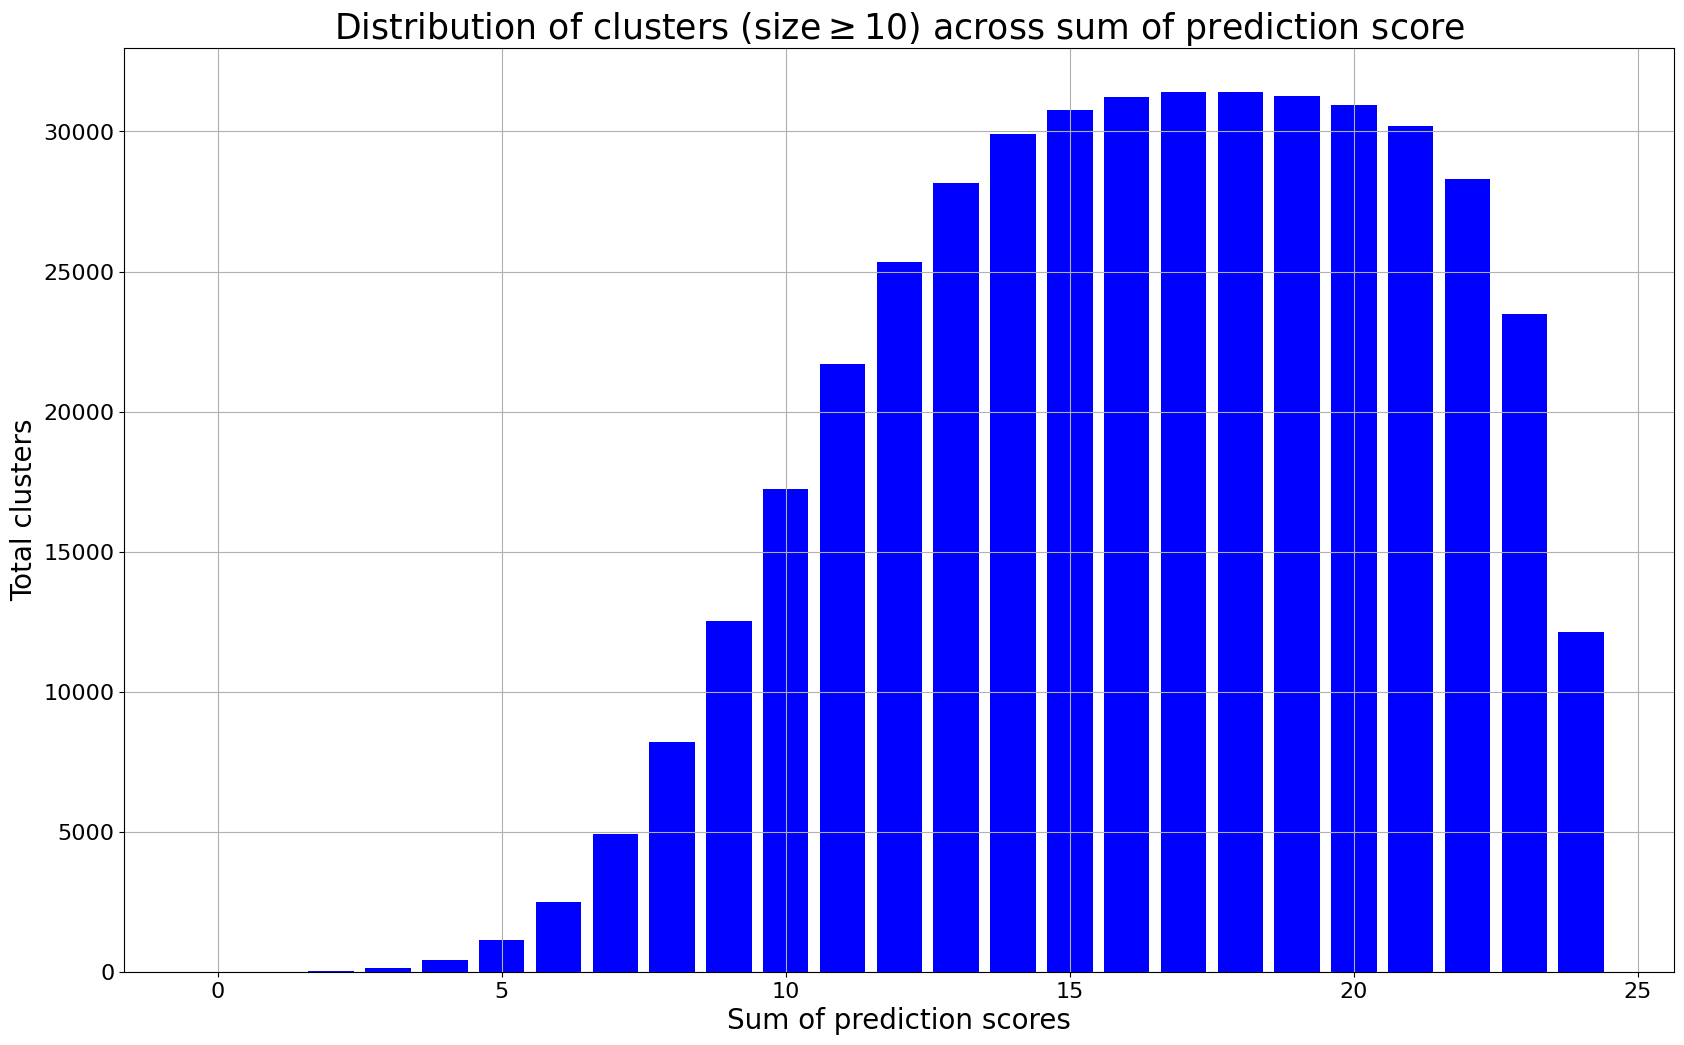

In [102]:
print(lim)
tmp = data[data.ClsID.isin(df_count[df_count.member_count>=lim].ClsID.unique())].groupby('prediction_score')['ClsID'].apply(lambda x: x.nunique()).reset_index()
tmp.columns = ['prediction_score', 'Total clusters']
display(tmp.head(30))
plt.figure(figsize=(20, 12))
plt.bar(tmp['prediction_score'], tmp['Total clusters'], color='blue')
plt.xlabel('Sum of prediction scores', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Total clusters', fontsize=20)
plt.title(f'Distribution of clusters (size$\\geq {lim}$) across sum of prediction score', fontsize=25)
plt.grid()
plt.show()

,prediction_score,sequence
0,23,160069
1,24,29254


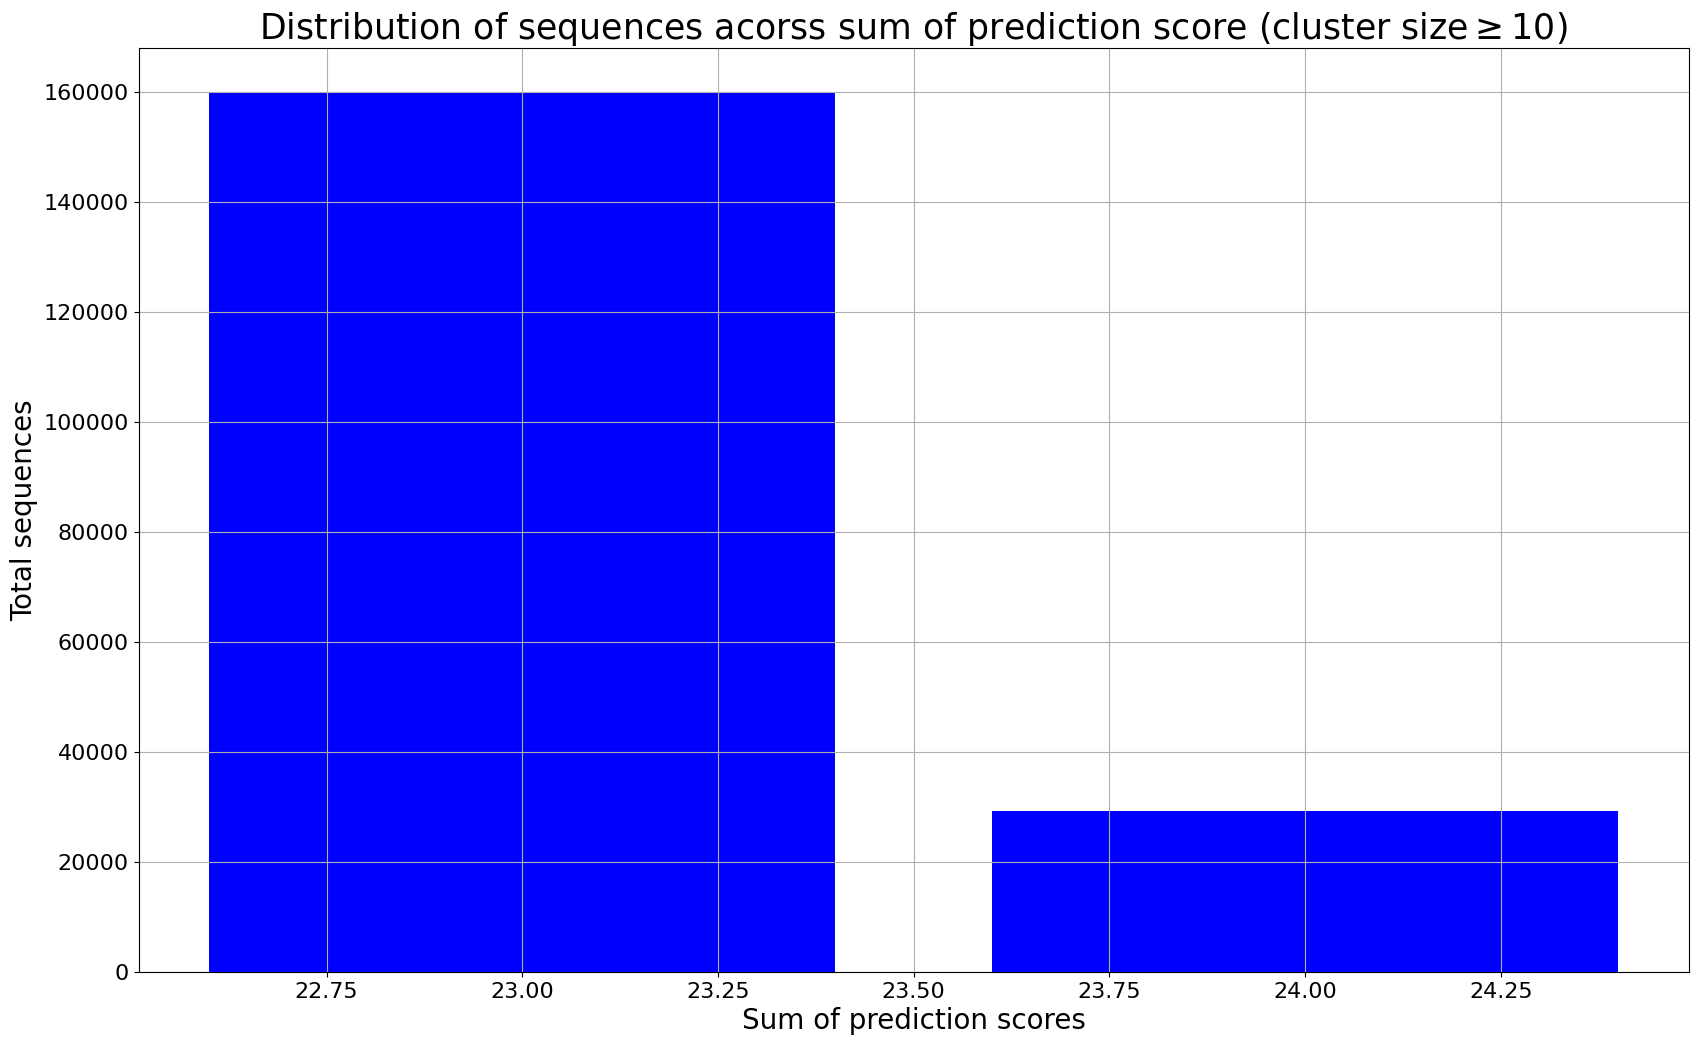

In [67]:
tmp = data[data.ClsID.isin(df_count[df_count.member_count>=lim].ClsID.unique())].groupby('prediction_score')['sequence'].apply(lambda x: x.nunique()).reset_index()
display(tmp.head(30))
plt.figure(figsize=(20, 12))
plt.bar(tmp['prediction_score'], tmp['sequence'], color='blue')
plt.xlabel('Sum of prediction scores', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Total sequences', fontsize=20)
plt.title(f'Distribution of sequences acorss sum of prediction score (cluster size$\\geq {lim}$)', fontsize=25)
plt.grid()
plt.show()

10


,ClsID,prediction_score
0,1,23.137705
1,2,23.161232
2,3,23.125828
3,4,23.155878
4,5,23.172840


23.0 23.5


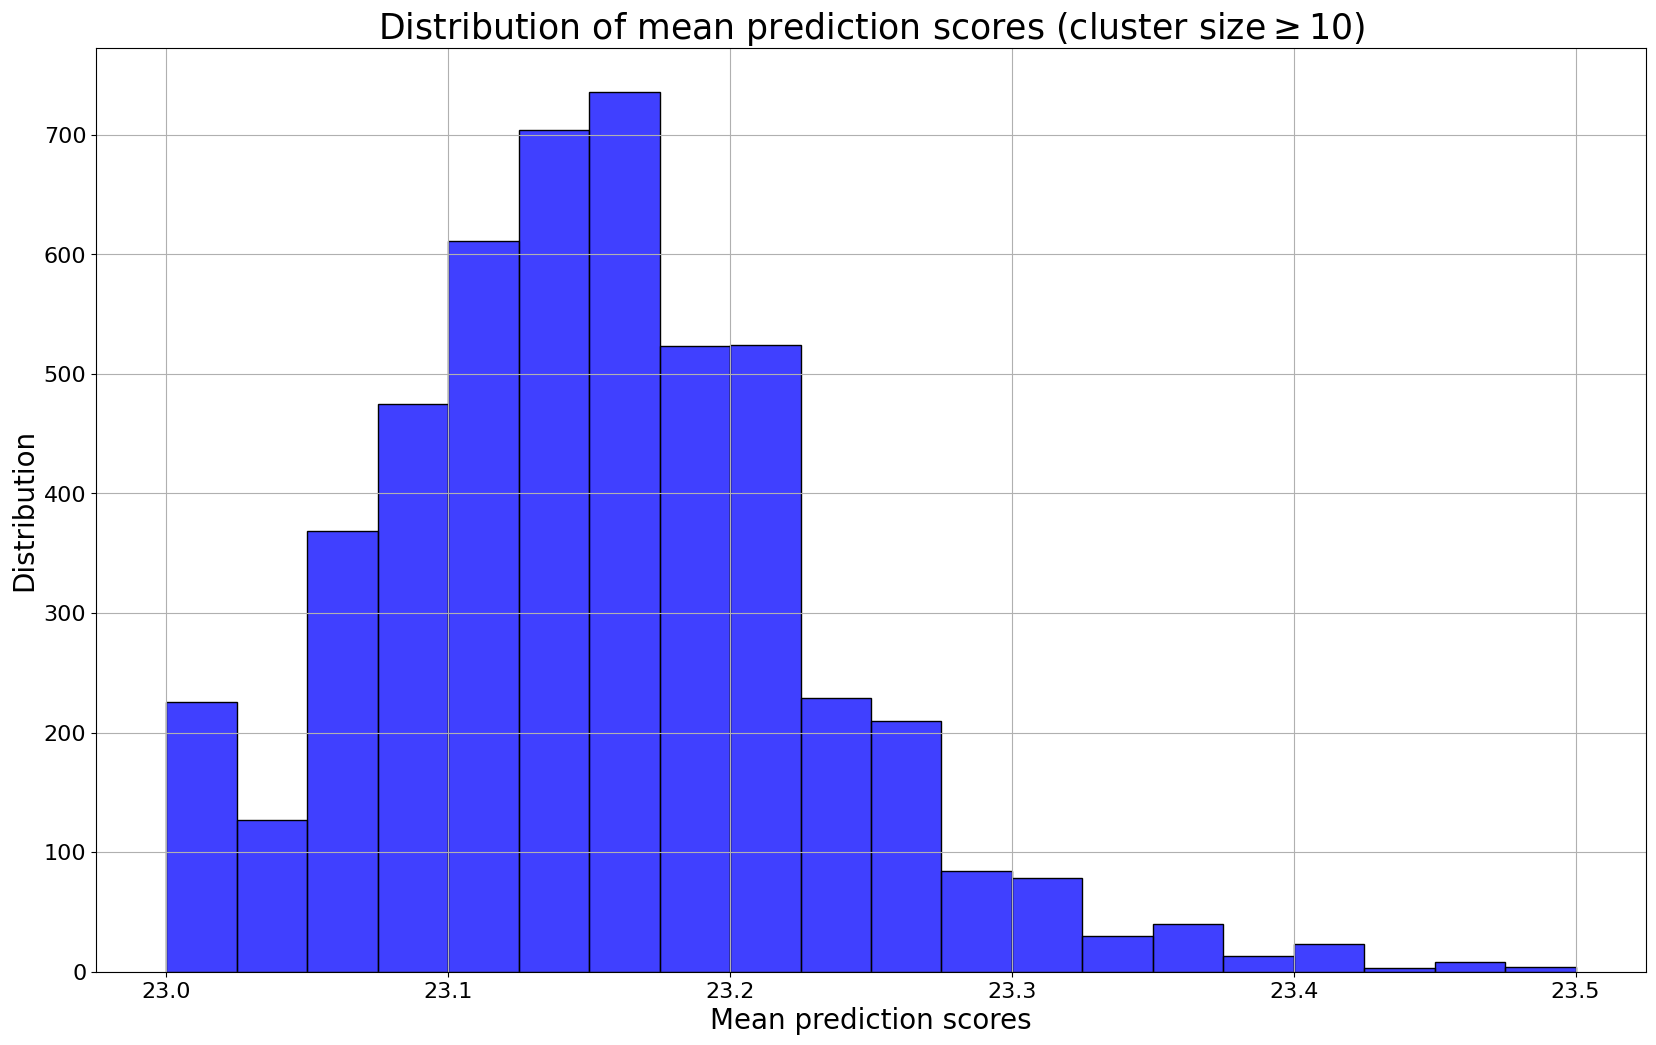

In [72]:
print(lim)
tmp = data[data.ClsID.isin(df_count[df_count.member_count>=lim].ClsID.unique())].groupby('ClsID')['prediction_score'].apply(lambda x: x.mean()).reset_index()
display(tmp.head())
print(tmp.prediction_score.min(), tmp.prediction_score.max())
plt.figure(figsize=(20, 12))
#plt.bar(tmp['ClsID'], tmp['prediction_score'], color='blue')
sns.histplot(tmp['prediction_score'], bins=20, color='blue')
plt.xlabel('Mean prediction scores', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Distribution', fontsize=20)
plt.title(f'Distribution of mean prediction scores (cluster size$\\geq {lim}$)', fontsize=25)
plt.grid()
plt.show()

In [73]:
df_agg = data[data.ClsID.isin(df_count[df_count.member_count>=lim].ClsID.unique())].groupby('ClsID').agg({
    'prediction_score': ['mean', 'std'],
    'sequence':'count'
}).reset_index()
df_agg.columns = df_agg.columns.map('_'.join).str.strip('|')
df_agg.rename(columns={
    'sequence_count': 'Count',
    'ClsID_':'ClsID'
}, inplace=True)
display(df_agg.head())
print(df_agg.prediction_score_mean.min(), df_agg.prediction_score_mean.max())
df_agg.to_csv(os.path.join(data_path, 'cluster_mean_std_pred_score_count_IDS_80_High_23_24_geq10.csv'), index=False)

,ClsID,prediction_score_mean,prediction_score_std,Count
0,1,23.137705,0.345156,305
1,2,23.161232,0.367911,1104
2,3,23.125828,0.332759,151
3,4,23.155878,0.362980,757
4,5,23.172840,0.380464,81


23.0 23.5


In [93]:
tmp = data.groupby('ClsID')['prediction_score'].apply(lambda x: x.mean()).reset_index()
tmp.prediction_score.min(), tmp.prediction_score.max()

(np.float64(2.0), np.float64(10.0))

In [94]:
df_agg['prediction_score_mean'].min(), df_agg['prediction_score_mean'].max()

(np.float64(2.0), np.float64(10.0))

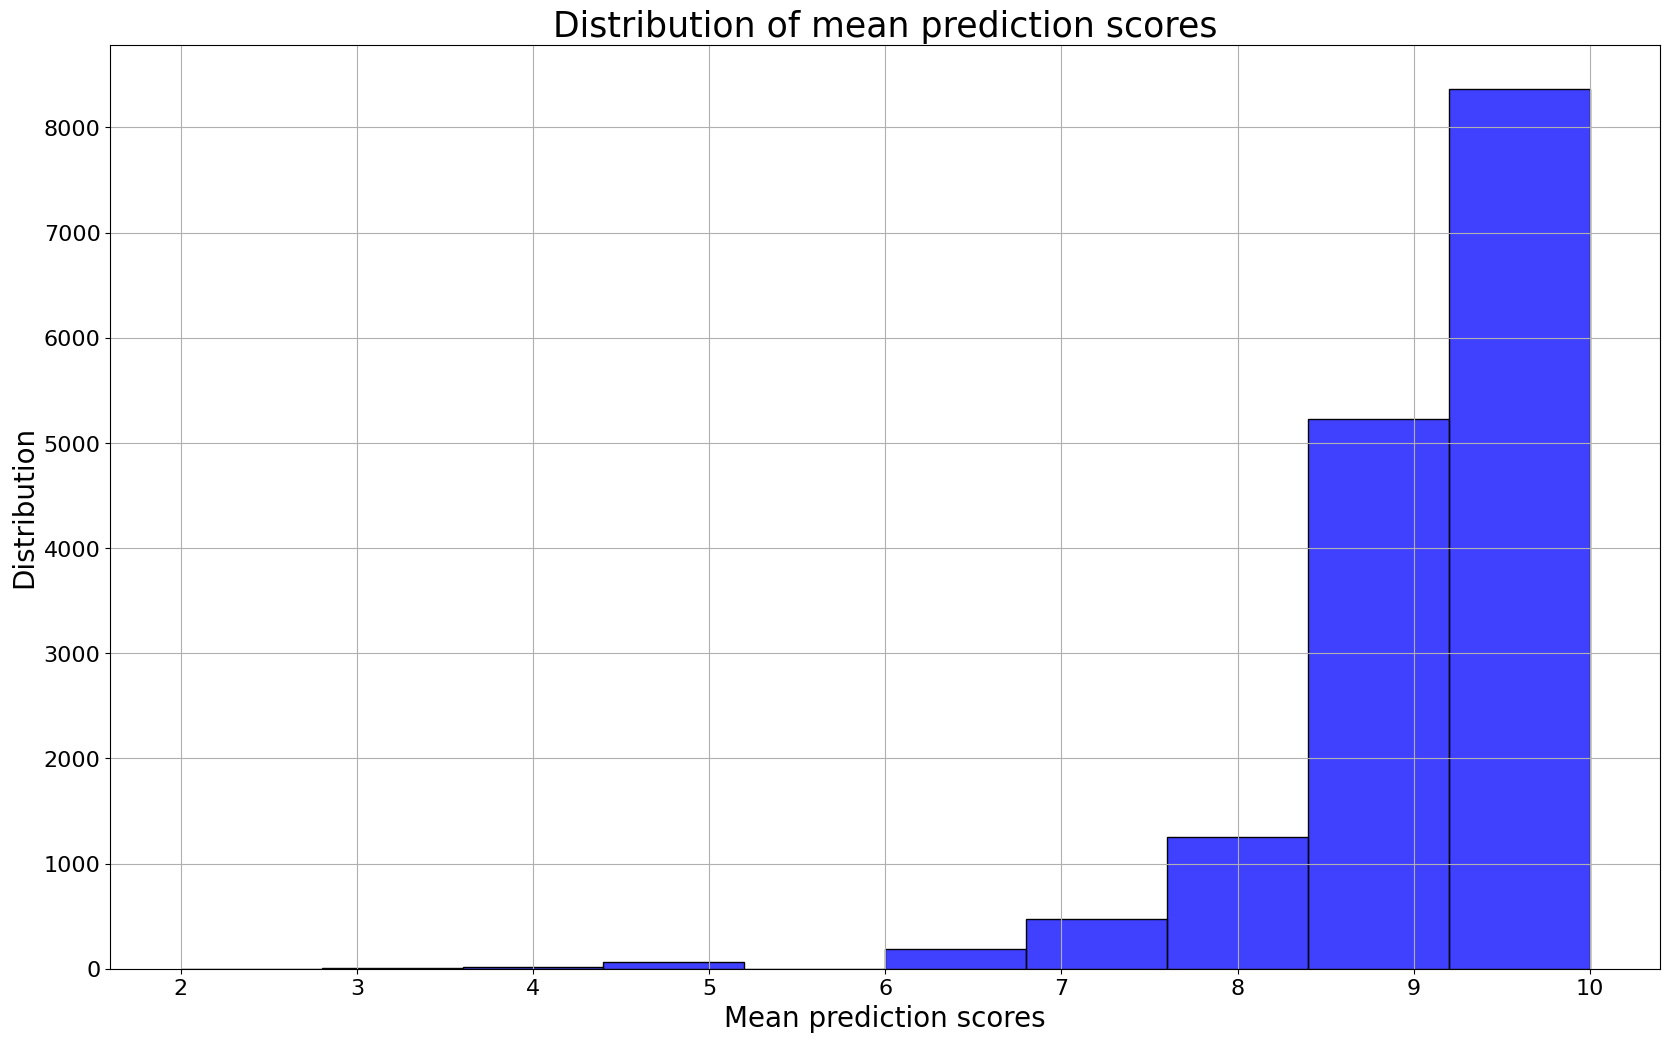

In [95]:
plt.figure(figsize=(20, 12))
#plt.bar(tmp['ClsID'], tmp['prediction_score'], color='blue')
sns.histplot(df_agg['prediction_score_mean'], bins=10, color='blue')
plt.xlabel('Mean prediction scores', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Distribution', fontsize=20)
plt.title(f'Distribution of mean prediction scores', fontsize=25)
plt.grid()
plt.show()

In [96]:
data[data.prediction_score<=10].ClsID.nunique()

15599

In [50]:
df_agg = data[np.logical_and(data.prediction_score>=23, data.prediction_score<=24)].groupby('ClsID').agg({
    'prediction_score': ['mean', 'std'],
    'sequence':'count'
}).reset_index()
df_agg.columns = df_agg.columns.map('_'.join).str.strip('|')
df_agg.rename(columns={
    'sequence_count': 'Count',
    'ClsID_':'ClsID'
}, inplace=True)
display(df_agg.head())
df_agg.to_csv(os.path.join(data_path, 'cluster_mean_std_pred_score_count_IDS_80_High_23_24.csv'), index=False)

,ClsID,prediction_score_mean,prediction_score_std,Count
0,1,23.137681,0.344878,552
1,2,23.185714,0.391684,70
2,3,23.147627,0.354886,1138
3,4,23.198400,0.399114,625
4,5,23.166667,0.383482,18


## 3) Once the clusters of greatest interest have been identified this way, I would list out their members so that we can search the sequences for patterns.  If you can send me a CSV file with that information I can do STREME searches, for instance.  I've found that the web version of STREME works well with sets of up to 10,000 sequences.  I doubt that any of the clusters will have so many members; if anything, my fear is that the cluster sizes will be too small to find statistically significant trends.  This might push us to using a lower % identity in order to increase cluster size (to >100 members, for example), but then the motifs might not be as clear...

In [23]:
df_cls.head()

,Perc,Total clusters,Singleton,Non-singleton,Perc_singleton,Perc_non_singleton
0,40,51521,51520,1,99.998,0.002
1,50,517438,517431,7,99.999,0.001
2,62,4869,3353,1516,68.864,31.136
3,66,3186,401,2785,12.586,87.414
4,67,4810,1034,3776,21.497,78.503


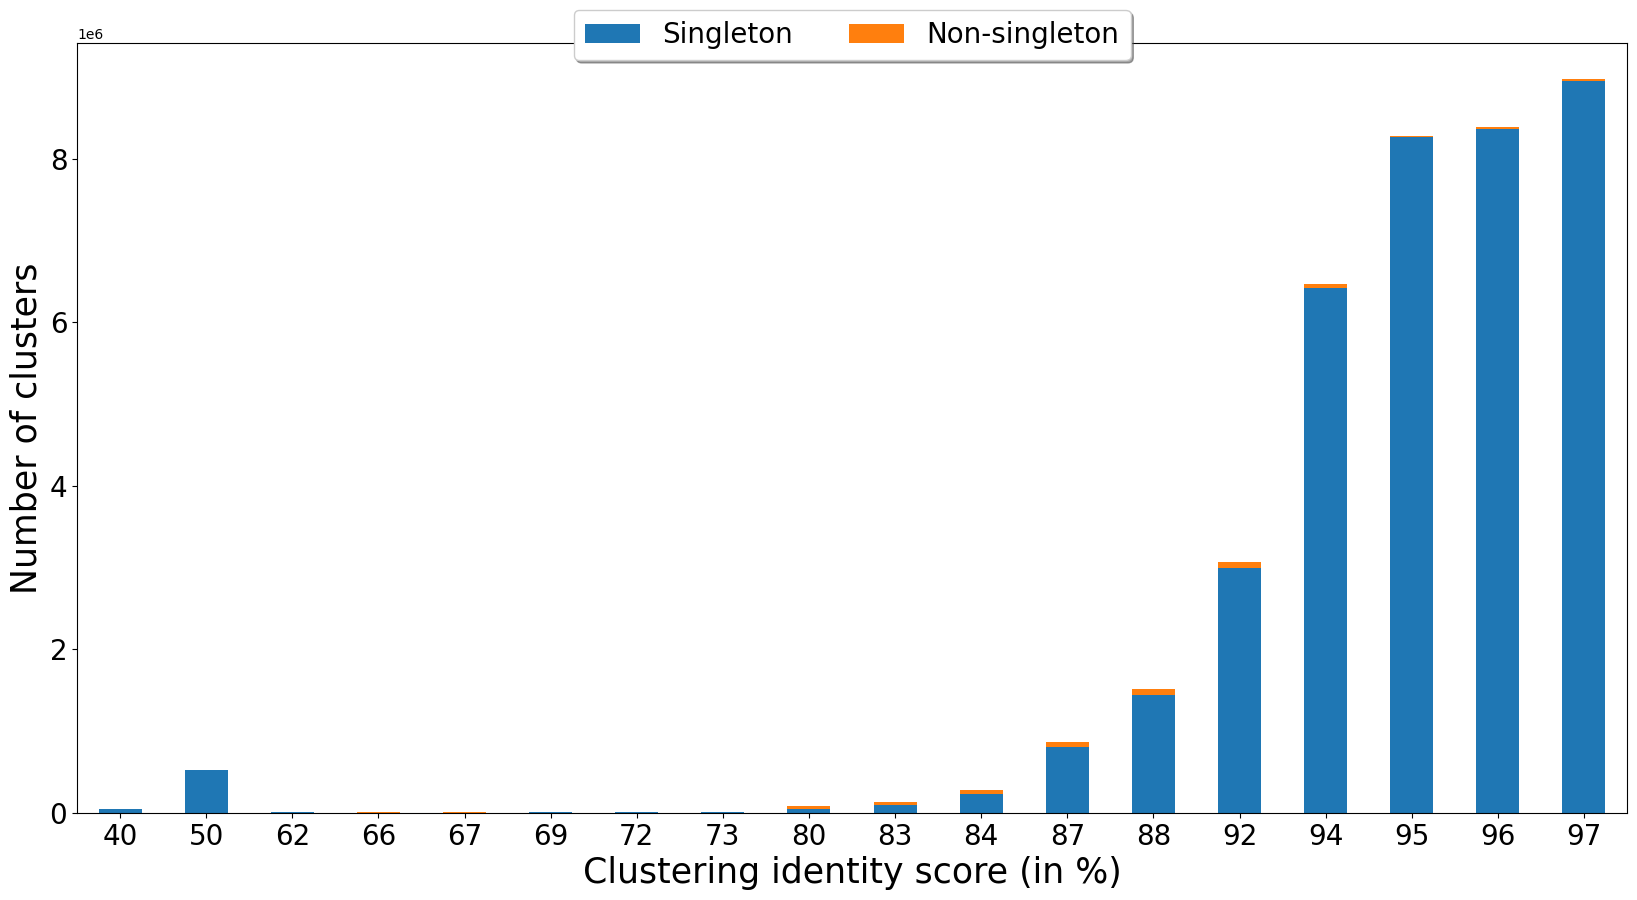

In [22]:
df_cls.plot(x='Perc', y=['Singleton', 'Non-singleton'], logy=False, kind='bar', figsize=(20,10), fontsize=20, rot=0, stacked=True, mark_right=True)
plt.ylabel('Number of clusters', fontsize=25)
plt.xlabel('Clustering identity score (in %)', fontsize=25)
plt.legend(fontsize=20, bbox_to_anchor=(0.5, 1.01), loc='center', ncol=2, fancybox=True, shadow=True)
plt.show()

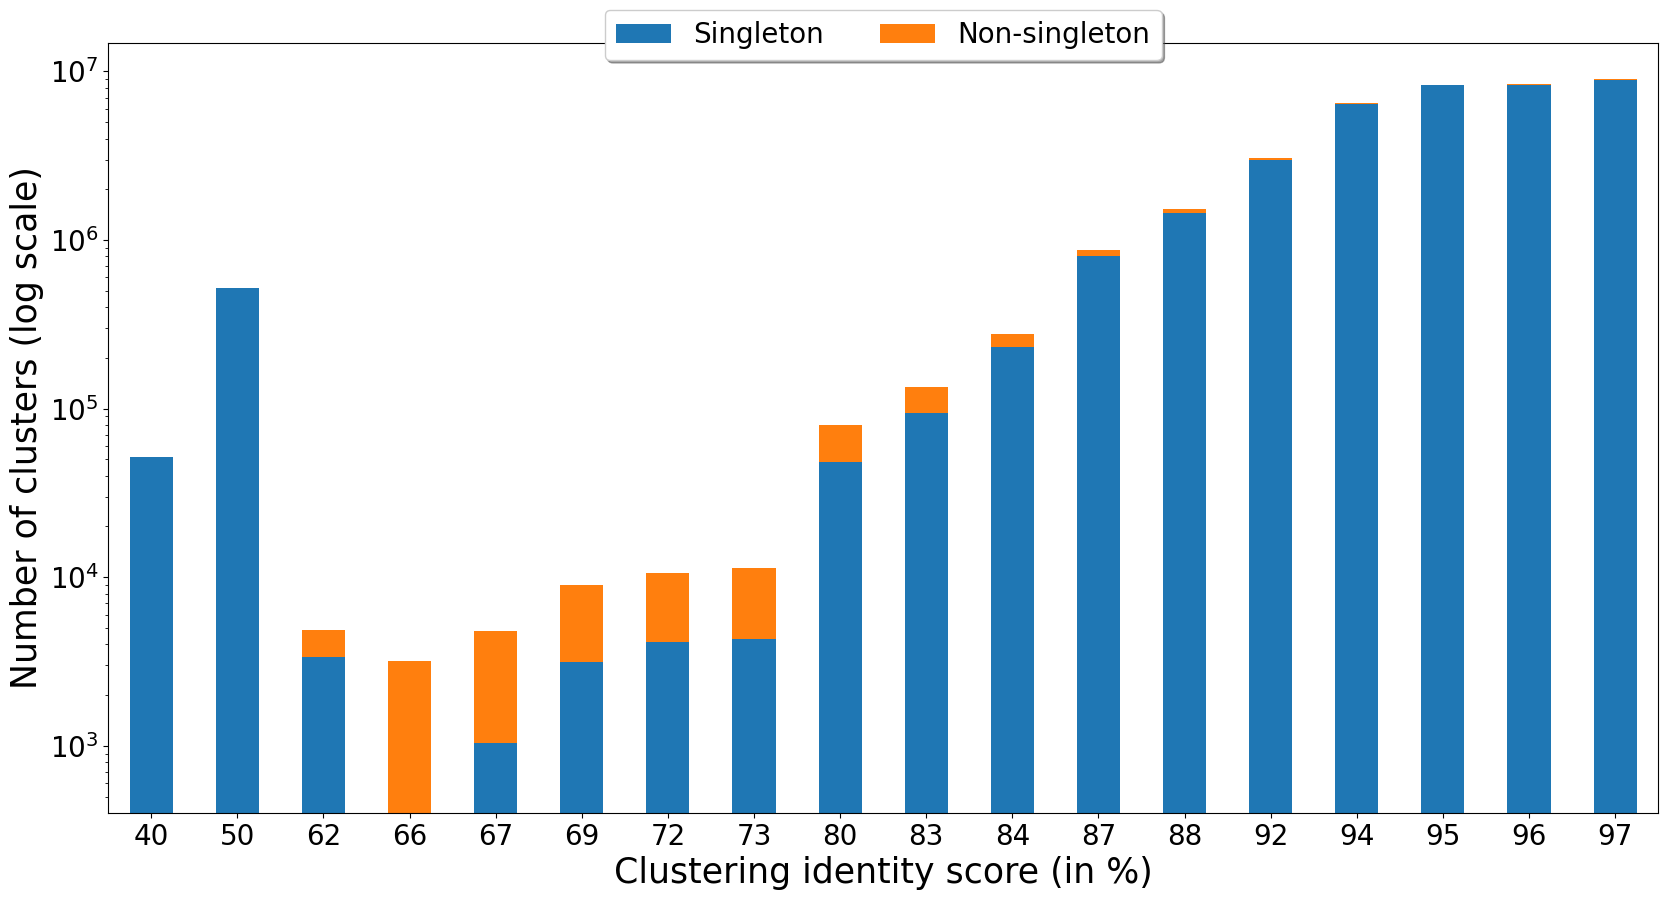

In [24]:
df_cls.plot(x='Perc', y=['Singleton', 'Non-singleton'], logy=True, kind='bar', figsize=(20,10), fontsize=20, rot=0, stacked=True, mark_right=True)
plt.ylabel('Number of clusters (log scale)', fontsize=25)
plt.xlabel('Clustering identity score (in %)', fontsize=25)
plt.legend(fontsize=20, bbox_to_anchor=(0.5, 1.01), loc='center', ncol=2, fancybox=True, shadow=True)
plt.show()

,Perc,Total clusters,Singleton,Non-singleton
0,40,51521,51520,1
1,50,517438,517431,7
2,62,4869,3353,1516
3,66,3186,401,2785
4,67,4810,1034,3776
5,69,8989,3130,5859
6,72,10567,4139,6428
7,73,11413,4314,7099
8,80,55633,16020,39613
9,95,6612573,6561577,50996


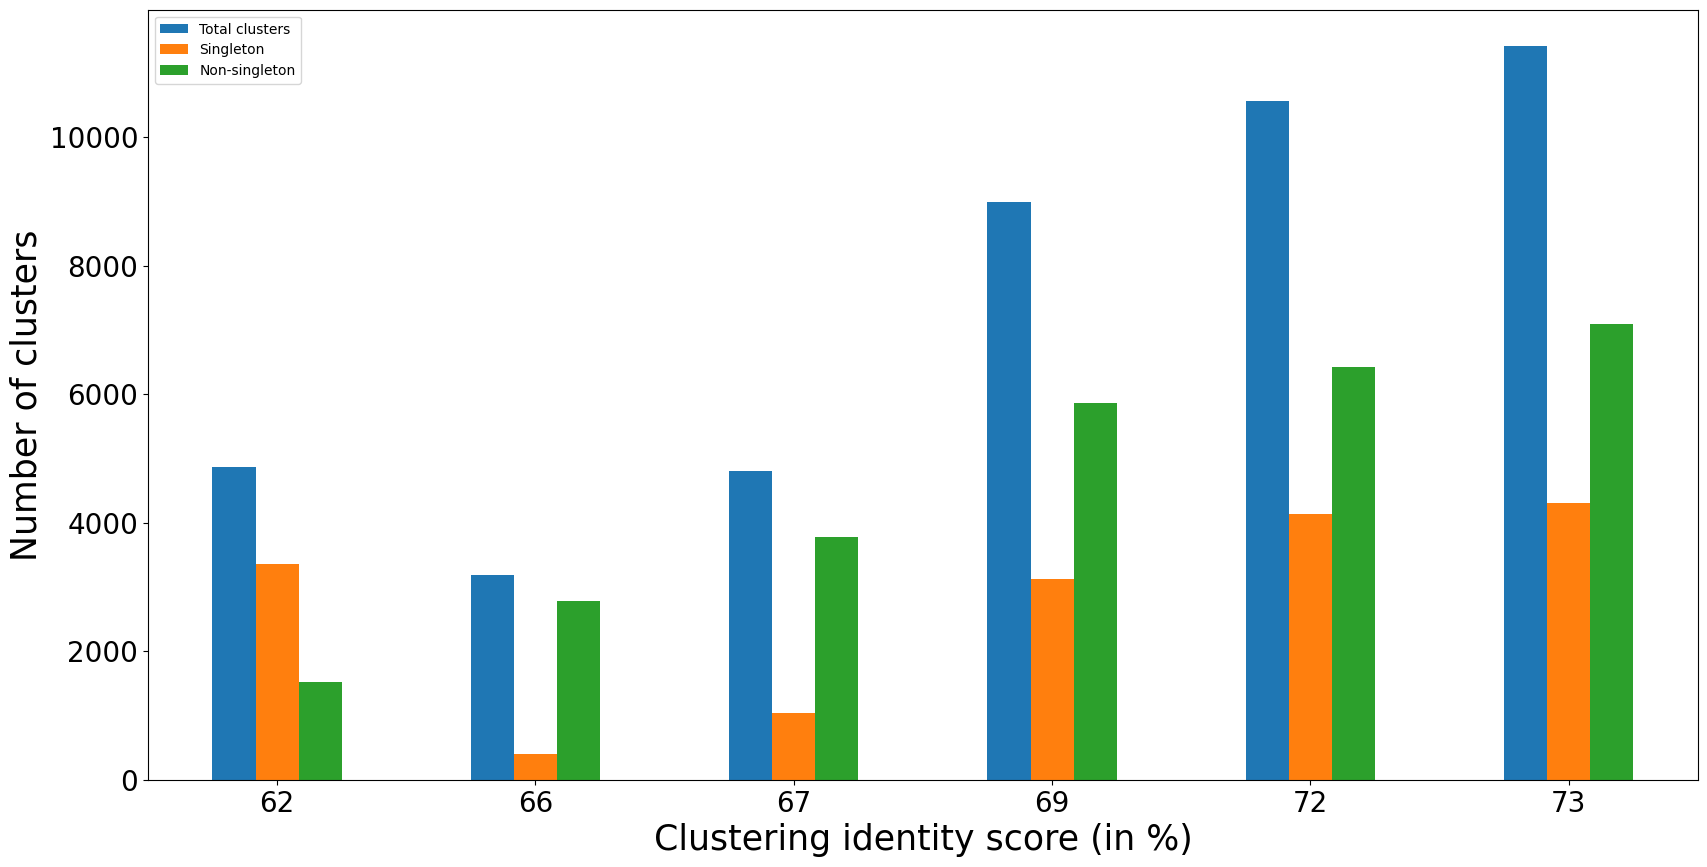

In [ ]:
df_cls = pd.DataFrame(res, columns=['Perc', 'Total clusters', 'Singleton', 'Non-singleton'])
display(df_cls)
df_cls[(df_cls.Perc>60)&(df_cls.Perc<80)].plot(x='Perc', y=['Total clusters', 'Singleton', 'Non-singleton'], kind='bar', figsize=(20,10), fontsize=20, rot=0)
plt.ylabel('Number of clusters', fontsize=25)
plt.xlabel('Clustering identity score (in %)', fontsize=25)
plt.show()

2785
Cluster 1 has 434021 members.
(2785, 2)
2785


(8988837, 7)

In [ ]:
tmp = data.groupby('ClsID')['seq_index'].apply(lambda x: len(x)).reset_index()
tmp = tmp[tmp.seq_index>500].sort_values('seq_index', ascending=False).reset_index(drop=True)
print(tmp.ClsID.nunique(), tmp.seq_index.min(), tmp.seq_index.max())
tmp.head(10)

1929 501 434021


,ClsID,seq_index
0,1,434021
1,2,310367
2,4,113250
3,127,107987
4,104,106958
5,5,80327
6,136,73533
7,122,71586
8,165,70782
9,25,61849


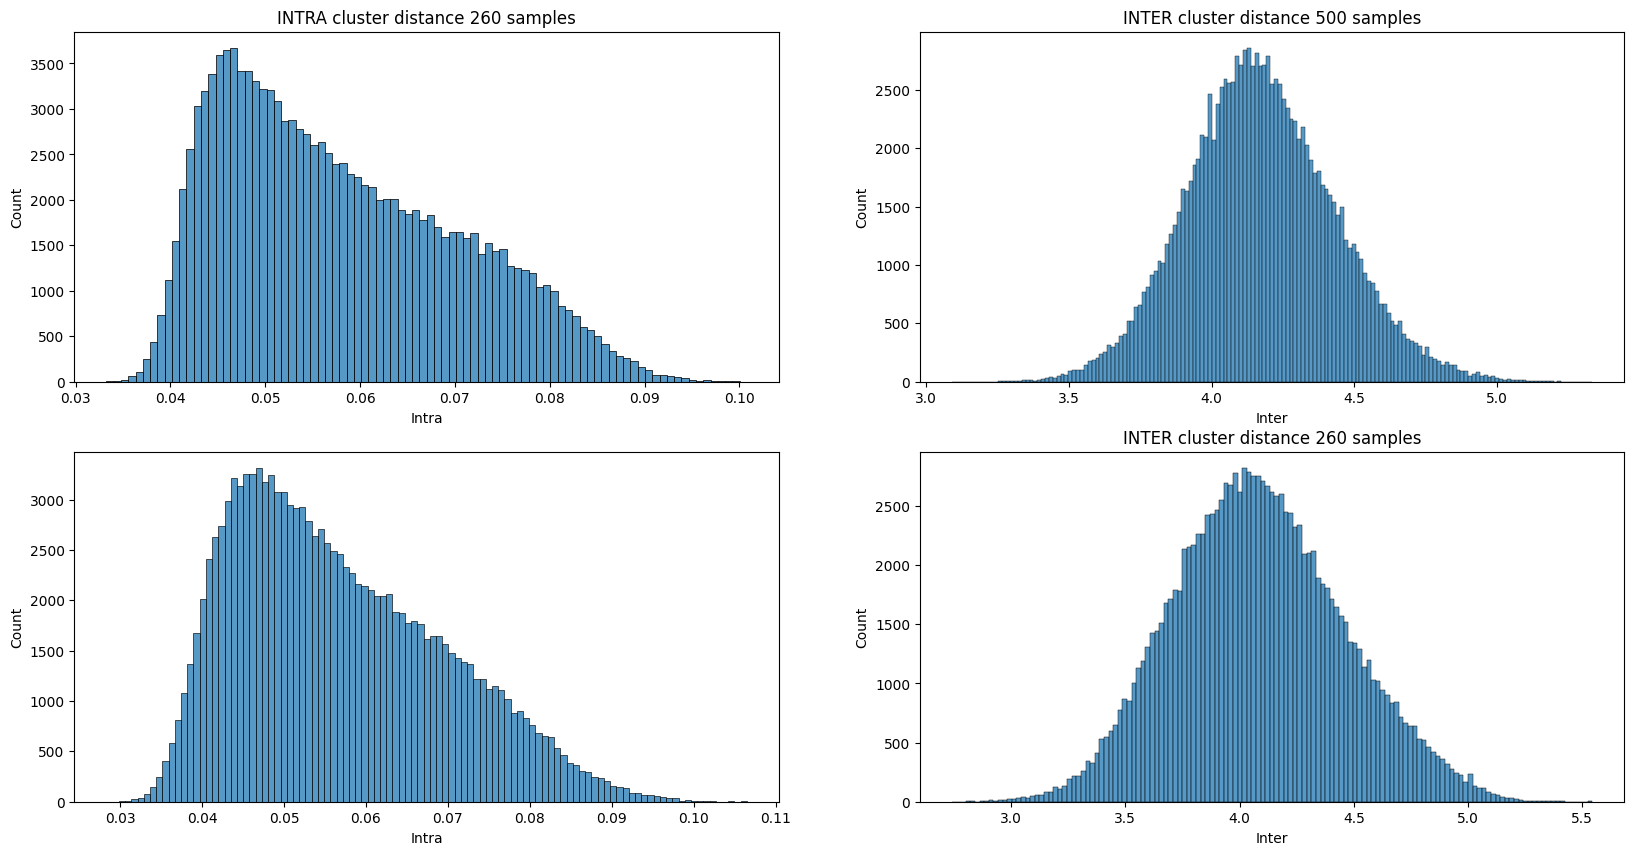

In [ ]:
df_res_1 = pd.read_csv(os.path.join(data_path, 'Intra_inter_distance_66_100_600.csv'))
df_res_2 = pd.read_csv(os.path.join(data_path, 'Intra_inter_distance_66_0_260.csv'))

fig, ax = plt.subplots(2, 2, figsize=(20,10))

sns.histplot(df_res_1, x='Intra', ax=ax[0,0])
ax[0,0].set_title('INTRA cluster distance 500 samples')
sns.histplot(df_res_2, x='Intra', ax=ax[1,0])
ax[0,0].set_title('INTRA cluster distance 260 samples')
#plt.show()
sns.histplot(df_res_1, x='Inter', ax=ax[0,1])
ax[0,1].set_title('INTER cluster distance 500 samples')
sns.histplot(df_res_2, x='Inter', ax=ax[1,1])
ax[1,1].set_title('INTER cluster distance 260 samples')
plt.show()

In [ ]:
"""tmp = data[data.ClsID==1].sort_values('seq_index')
display(tmp.head())
print(tmp.shape)
with open('../Data/cluster_1.fa', 'w') as f:
    [f.write(f">g1|{a}\n{b}\n") for a,b in zip(tmp.seq_index.values.tolist(), tmp.sequence.values.tolist())]

"""

,sequence,seq_index,predictions,gc_content,ClsID,Status,Score
0,ACCCATGTCTGGCGAAAGTTATACA,146,20,0.44,1,M,0.9032
1,TGGCAGAGATAAACTCCACCGCAGT,175,21,0.52,1,M,0.8278
3,TCAACCTTGGCCGTGAGATATGTAA,989,11,0.44,1,M,0.8422
4,CCGAAACGGTGCAGATCCAACTTAA,1321,22,0.48,1,M,0.8331
5,CTTAGGTCTCCAACGTAGCGATGAA,1343,24,0.48,1,M,0.8160


(47766, 7)


data.sort_values('seq_index', inplace=True)
with open(os.path.join(data_path, "random_25mers_10M.fasta"), "w") as f:
    [f.write(f"{a}\n{b}\n") for a,b in zip(data.char,data.sequence)]

## Get raw and aggregate data

In [2]:
def get_raw_And_aggregate_data(data_path, cfilename='output_Aug_26_66.txt', gfilename='gc_content_predictions.csv'):   
    df_tmp1 = pd.read_csv(os.path.join(data_path, cfilename), sep='\t', header=None)
    df_tmp1.columns = ['ClsID','SeqID','Score','Status']
    df_tmp1['seq_index'] = [int(x.split('|')[1]) for x in df_tmp1.SeqID.values]
    #print(df_tmp1.shape, df_tmp1.seq_index.min(), df_tmp1.seq_index.max())
    #display(df_tmp1.head())

    df_tmp2 = pd.read_csv(os.path.join(data_path, gfilename))
    df_tmp2.predictions = df_tmp2.predictions.astype(int)
    df_tmp2['seq_index'] = df_tmp2.index

    #print(df_tmp2.shape)
    #display(df_tmp2.head())

    data = df_tmp1.merge(df_tmp2, on=['seq_index'])
    del [df_tmp1, df_tmp2]
    data = data.loc[data.Status.isin(['C', 'M']), ['sequence', 'seq_index', 'predictions', 'gc_content', 'ClsID', 'Status', 'Score']]
    #print(data.shape)
    #data['char'] = [f">gi|{a}|{b}|{c:.2f}" for a,b,c in zip(data.seq_index, data.predictions, 100*data.gc_content)]
    #data[['sequence','predictions', 'gc_content', 'ClsID']].to_csv(os.path.join(data_path, "Cluster_for_pred_score_whole.csv"), index=False)
    #display(data.head())

    tmp = data.groupby('ClsID')['seq_index'].apply(lambda x: len(x)).reset_index()
    tmp = tmp[tmp.seq_index>=2]
    print(f"Total non-singular clusters={tmp.ClsID.nunique()}")
    print(f"Cluster {tmp.ClsID[tmp.seq_index==tmp.seq_index.max()].values[0]} has {tmp.seq_index.max()} members.")
    print(tmp.shape)
    #print(tmp.ClsID.sample(10))

    data = data[data.ClsID.isin(tmp.ClsID.unique())]
    del [tmp]
    print(f"Total non-singular clusters={data.ClsID.nunique()}")
    display(data.head())

    df_agg = data.groupby('ClsID').agg({
        'predictions': ['mean', 'std', 'count']
    }).reset_index()
    df_agg.columns = df_agg.columns.map('_'.join).str.strip('|')
    df_agg.rename(columns={
        'predictions_count': 'Count',
        'ClsID_':'ClsID'
    }, inplace=True)
    display(df_agg.head())

    return data, df_agg


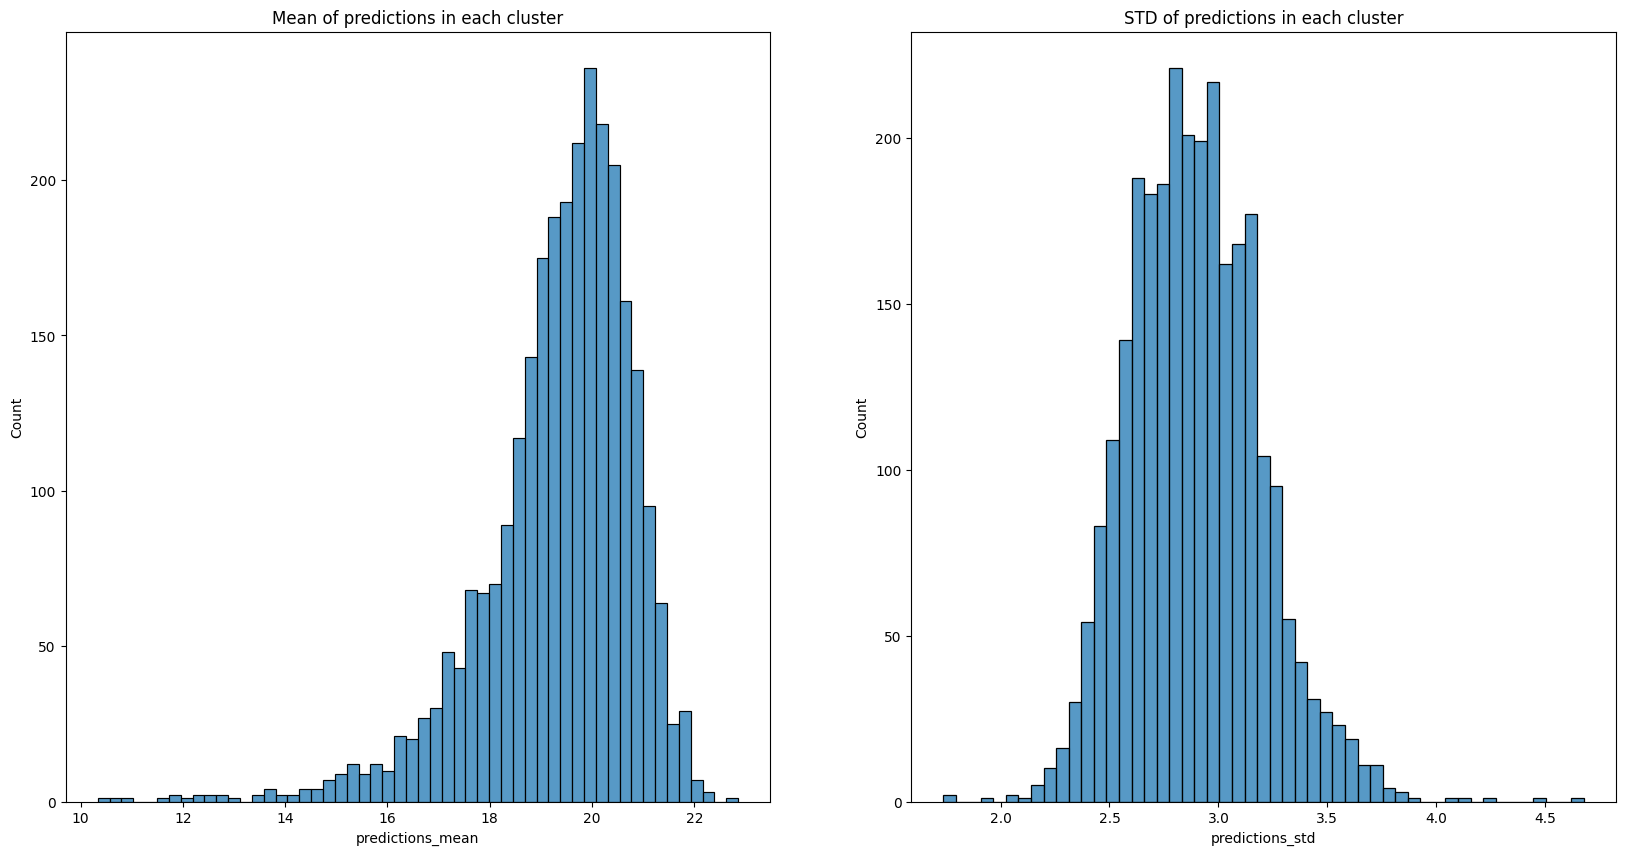

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
sns.histplot(df_agg, x='predictions_mean', ax=ax[0])
ax[0].set_title('Mean of predictions in each cluster')

sns.histplot(df_agg, x='predictions_std', ax=ax[1])
ax[1].set_title('STD of predictions in each cluster')
plt.show()

In [ ]:
tmp = df_agg[df_agg.predictions_mean>21].sort_values('Count', ascending=False).reset_index(drop=True)
print(tmp.shape[0])
tmp.head(20)

224


,ClsID,predictions_mean,predictions_std,Count
0,225,21.084356,2.645715,24112
1,318,21.453879,2.405368,14050
2,284,21.184374,2.695439,13836
3,1407,21.183286,2.535875,12074
4,2390,21.097181,2.714911,11669
5,530,21.857509,2.460074,11306
6,255,21.036032,2.543874,11129
7,241,21.002877,2.477294,9038
8,130,21.222164,2.449243,7643
9,298,21.002341,2.809889,7263


In [ ]:
tmp = df_agg[df_agg.predictions_mean<17].sort_values('Count', ascending=False).reset_index(drop=True)
print(tmp.shape[0])
tmp.head(20)

181


,ClsID,predictions_mean,predictions_std,Count
0,348,16.982700,3.205010,5607
1,719,16.814606,3.328686,5135
2,86,15.240830,3.663220,4144
3,203,16.801783,3.282093,3814
4,2015,16.880914,3.089863,3720
5,2160,16.219004,3.182670,3694
6,759,16.479871,3.571614,3403
7,808,15.758696,3.590749,3191
8,33,16.021350,3.708292,3185
9,495,16.685143,3.625852,3103


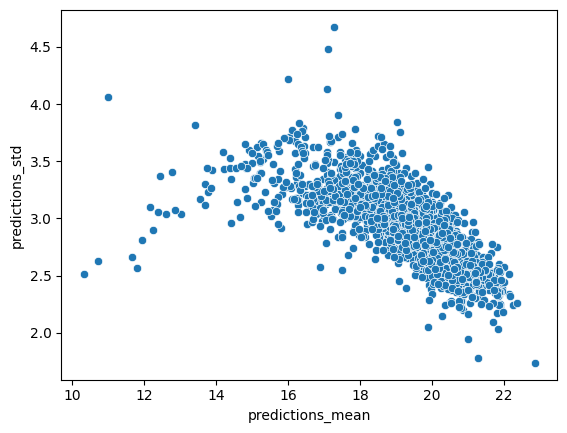

In [ ]:
# Group based on low prediction and high prediction score
sns.scatterplot(data=df_agg, x='predictions_mean', y='predictions_std')
plt.show()

### Motif analysis

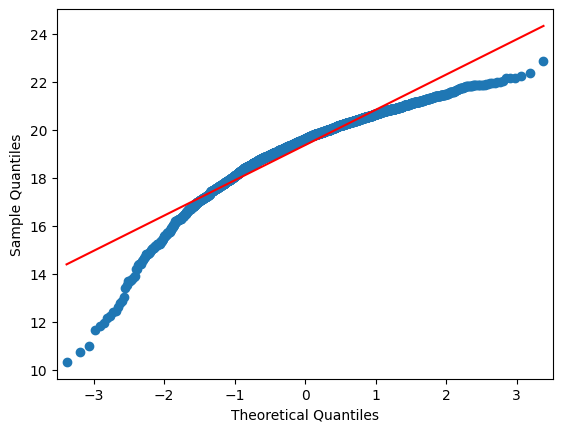

17.0 21.0


In [19]:
qval = np.quantile(df_agg.predictions_mean, [0.09, 0.9])
qqplot(df_agg.predictions_mean, line ='s')
plt.show()
qval[0] = np.floor(qval[0])
qval[1] = np.ceil(qval[1])
print(qval[0], qval[1])

In [3]:
def get_cluster_bands(df_agg, low, high, nmid=100):
    low_score_clusters = sorted(df_agg.ClsID[df_agg.predictions_mean<low].unique())
    high_score_clusters = sorted(df_agg.ClsID[df_agg.predictions_mean>high].unique())
    mid_score_clusters = sorted(df_agg.ClsID[np.logical_and(df_agg.predictions_mean>=low, df_agg.predictions_mean<=high)].unique())
    lc = len(low_score_clusters)
    hc = len(high_score_clusters)
    mc = len(mid_score_clusters)

    sl = set(low_score_clusters)
    sh = set(high_score_clusters)
    sm = set(np.random.choice(mid_score_clusters, size=nmid, replace=False))

    def print_val(a,b):
        print(a, b, a+b, (a+b)*(a+b-1)//2)

    print_val(lc, mc)
    print_val(mc, hc)
    print_val(lc, hc)

    return sl, sh, sm

In [10]:
def process_time(start: float, end: float, s=""):
    elapsed = end - start
    hours, remainder = divmod(elapsed, 3600)
    minutes, seconds = divmod(remainder, 60)
    print(f"Time taken{' for ['+s+']' if len(s)>0 else ''}: {int(hours)}h {int(minutes)}m {seconds:.2f}s")

class SignificantClusters:
    def __init__(self, cluster_labels_A, cluster_labels_B, typeA='Low', typeB='High'):
        self.sl = set(cluster_labels_A)
        self.sh = set(cluster_labels_B)
        self.typeA = typeA
        self.typeB = typeB
        self.cluster_labels = sorted(list(self.sl.union(self.sh)))

        print(f"Total clusters to process={len(self.cluster_labels)}")
        print(f"{self.typeA} scored clusters={len(self.sl)}")
        print(f"{self.typeB} scored clusters={len(self.sh)}")

        self.significant_inter_clusters = {
            'ttest_ind':[],
            'mannwhitneyu':[],
            'wilcoxon':[],
            'fligner':[]
        }

        self.significant_intra_clusters = {
            'ttest_ind':[],
            'mannwhitneyu':[],
            'wilcoxon':[],
            'fligner':[]
        }

    def get_sig_intra_clusters(self):
        return self.significant_intra_clusters
    
    def get_sig_inter_clusters(self):
        return self.significant_inter_clusters

    def get_members(self, data, i,j):
        score1 = data.predictions[data.ClsID==self.cluster_labels[i]].values
        score2 = data.predictions[data.ClsID==self.cluster_labels[j]].values
        return score1, score2

    def get_cluster_id_in_order(self, c1, c2):
        return (c1, c2) if c1<=c2 else (c2, c1)

    def hypotheis_test(self, score1, score2, c1, c2, fname):
        # Perform the test
        _, p_val = fname(score1, score2)

        # Adjust for multiple hypothesis testing
        p_val_adj = multipletests(p_val, method='fdr_bh')[1]

        if p_val_adj < 0.05:
            if (c1 in self.sl and c2 in self.sh) or (c1 in self.sh and c2 in self.sl):
                self.significant_inter_clusters[fname.__name__].append(self.get_cluster_id_in_order(c1, c2))
            else:
                self.significant_intra_clusters[fname.__name__].append(self.get_cluster_id_in_order(c1, c2))

    def find_significant_clusters(self, data):
        st = timeit.default_timer()
        n = len(self.cluster_labels)
        for i in range(n):
            for j in range(i+1, n):
                c1 = self.cluster_labels[i]
                c2 = self.cluster_labels[j]

                score1 = data.predictions[data.ClsID==c1].values
                score2 = data.predictions[data.ClsID==c2].values
                min_sample = min(len(score1), len(score2))

                try:
                    # Perform the t-test
                    self.hypotheis_test(score1, score2, c1, c2, ttest_ind)

                    # Perform the Mann-Whitney U test
                    self.hypotheis_test(score1, score2, c1, c2, mannwhitneyu)

                    # Perform the Wilcoxon Signed-Rank Test
                    self.hypotheis_test(np.random.choice(score1, size=min_sample), np.random.choice(score2, size=min_sample), c1, c2, wilcoxon)

                    # Perform the Fligner-Killeen Test
                    self.hypotheis_test(score1, score2, c1, c2, fligner)

                except Exception as e:
                    print(f"Error for ({c1}, {c2}). Error details: {e}")

        process_time(st, timeit.default_timer(), s="Finding significant clusters")

    def save_results(self, result_path='./', add_timestamp=True):
        print('Inter cluster:')
        for k in self.significant_inter_clusters:
            print(f'{k}={len(self.significant_inter_clusters[k])}')

        print('Intra cluster:')
        for k in self.significant_intra_clusters:
            print(f'{k}={len(self.significant_intra_clusters[k])}')

        # Combined the significant cluster pairs those passes all tests
        setV = set(self.significant_inter_clusters['ttest_ind'])
        for k in self.significant_inter_clusters:
            if k in ['ttest_ind', 'wilcoxon']: continue
            setV = setV.intersection(set(self.significant_inter_clusters[k]))

        res = {
            'high_avg_score':[],
            'low_avg_score':[]
        }

        for h in self.sh:
            for l in self.sl:
                if h>l: h,l = l,h
                if (h,l) in setV: 
                    if h in self.sh:
                        res['high_avg_score'].append(h)
                        res['low_avg_score'].append(l)
                    else:
                        res['high_avg_score'].append(l)
                        res['low_avg_score'].append(h)

        fn = f"significant_clusters_{self.typeA}_{self.typeB}_avgscore{f'_{time.time()}' if add_timestamp else ''}.csv"
        df = pd.DataFrame(res)
        df.to_csv(os.path.join(result_path, fn), index=False)
        print(f"File savesd to {os.path.join(result_path, fn)}")
        return os.path.join(result_path, fn)


In [5]:
data, df_agg = get_raw_And_aggregate_data(data_path, 'output_Aug_26_66.txt', 'gc_content_predictions.csv')
sl, sh, sm = get_cluster_bands(df_agg, 17.0, 21.0, nmid=100)
low_score_clusters, high_score_clusters, mid_score_clusters = list(sl), list(sh), list(sm)
print(len(low_score_clusters), len(high_score_clusters), len(mid_score_clusters))

Total non-singular clusters=2785
Cluster 1 has 434021 members.
(2785, 2)
Total non-singular clusters=2785


,sequence,seq_index,predictions,gc_content,ClsID,Status,Score
0,GTTCTATAGACATGAATGATTTGCG,0,17,0.36,1,M,0.6821
1,TCAGTAAATCGATTCCCTGGCGGAC,11,21,0.52,1,M,0.7313
2,GTGAATGGCAGGCTTTACTTACTCC,110,18,0.48,1,M,0.8246
3,CCTAATACTCGGAGAGGTTGGGAAC,142,22,0.52,1,M,0.6816
4,ACCCATGTCTGGCGAAAGTTATACA,146,20,0.44,1,M,0.7959


,ClsID,predictions_mean,predictions_std,Count
0,1,19.302213,2.996576,434021
1,2,20.344785,2.782225,310367
2,3,18.431855,3.028037,3089
3,4,19.376106,2.985612,113250
4,5,19.732182,2.939203,80327


181 2380 2561 3278080
2380 224 2604 3389106
181 224 405 81810
181 224 100


In [7]:
sc = SignificantClusters(low_score_clusters, high_score_clusters)
sc.find_significant_clusters(data)
sc.save_results(result_path=data_path, add_timestamp=True)

#significant_inter_clusters = sc.get_sig_inter_clusters()
#significant_intra_clusters = sc.get_sig_intra_clusters()

Total clusters to process=405
Low scored clusters=181
High scored clusters=224
Time taken for [Finding significant clusters]: 0h 28m 40.63s
Inter cluster:
ttest_ind=40544
mannwhitneyu=40544
wilcoxon=40145
fligner=36795
Intra cluster:
ttest_ind=21557
mannwhitneyu=21529
wilcoxon=20074
fligner=11268
File savesd to /Users/mkamruz/Public/SNL/Projects/5UTR/Data/significant_clusters_Low_High_avgscore_52676.606363708.csv


In [9]:
df_cls = pd.read_csv(os.path.join(data_path, 'significant_clusters_Low_High_avgscore_52676.606363708.csv'))
print(df_cls.shape)
display(df_cls.head())
print(df_cls.high_avg_score.nunique(), df_cls.low_avg_score.nunique())

(602, 2)


,high_avg_score,low_avg_score
0,2560,513
1,1537,513
2,1027,513
3,2564,513
4,1548,513


224 170


In [17]:
resultpath = '/adv'
t = resultpath.replace('.','').replace('/','')
t, resultpath

('adv', '/adv')

In [ ]:
hv = set(td.high_avg_score.values)
lv = set(td.low_avg_score.values)
sig_cls = list(hv.union(lv))
for cid in sig_cls:
    tmp = data[data.ClsID==cid].sort_values('seq_index')
    print(f"cluster {cid} data size={tmp.shape}")
    with open(os.path.join(data_path, f'motif/cluster_{cid}.fa'), 'w') as f:
        [f.write(f">g1|{a}\n{b}\n") for a,b in zip(tmp.seq_index.values.tolist(), tmp.sequence.values.tolist())]

cluster 26115 data size=(100, 7)
cluster 5178 data size=(208, 7)
cluster 12170 data size=(156, 7)
cluster 8138 data size=(178, 7)
cluster 29962 data size=(101, 7)
cluster 5464 data size=(182, 7)
cluster 14426 data size=(150, 7)
cluster 25826 data size=(179, 7)
cluster 1955 data size=(260, 7)
cluster 26917 data size=(163, 7)
cluster 7846 data size=(224, 7)
cluster 10280 data size=(164, 7)
cluster 18618 data size=(102, 7)
cluster 7467 data size=(130, 7)
cluster 37679 data size=(120, 7)
cluster 5359 data size=(382, 7)
cluster 26224 data size=(111, 7)
cluster 27891 data size=(158, 7)
cluster 19893 data size=(109, 7)
cluster 12089 data size=(146, 7)
cluster 33530 data size=(172, 7)
cluster 10555 data size=(159, 7)
cluster 17274 data size=(106, 7)


In [ ]:
len(sorted([int(x) for x in sig_cls]))

23

## Motif finding [STREME]

In [66]:
df_sig = pd.read_csv(os.path.join(data_path, 'significant_clusters_high_low_avgscore.csv'))
df_sig.head()

,high_avg_score,low_avg_score
0,1955,25826
1,1955,26115
2,1955,7846
3,1955,18618
4,1955,8138


In [85]:
motif_path = os.path.join(data_path, 'motif/results')
motif_seq = {
    'clsID':[],
    'class':[],
    'Motif_1':[],
    'Motif_2':[],
    'Motif_3':[],
    'Motif_4':[],
    'Motif_5':[],
}
for cid in set(df_sig.high_avg_score.values):
    motif_seq['clsID'].append(cid)
    motif_seq['class'].append('high')
    tmp = pd.read_csv(os.path.join(motif_path, f"cluster_{cid}/sequences.tsv"), sep='\t')
    turn=1
    for seq in tmp.motif_ID.unique():
        if seq=='#': continue
        motif_seq[f'Motif_{turn}'].append(seq[2:])
        turn+=1
    #display(tmp.head())
    #break

for cid in set(df_sig.low_avg_score.values):
    motif_seq['clsID'].append(cid)
    motif_seq['class'].append('low')
    tmp = pd.read_csv(os.path.join(motif_path, f"cluster_{cid}/sequences.tsv"), sep='\t')
    turn=1
    for seq in tmp.motif_ID.unique():
        if seq=='#': continue
        motif_seq[f'Motif_{turn}'].append(seq[2:])
        turn+=1
    #display(tmp.head())
    #break

tmp = pd.DataFrame(motif_seq)
tmp.to_csv(os.path.join(data_path, 'motif_high_low.csv'), index=False)
tmp

,clsID,class,Motif_1,Motif_2,Motif_3,Motif_4,Motif_5
0,1955,high,TAGAGTTCRG,CAGCGAGCS,ATACTCGAA,AAGTGCGC,ATCGCAGAG
1,33530,high,GCTCGCTAAC,ACGCCM,SKKCC,AAACGCGTTT,GTWGCAMGCGC
2,26917,high,AAGCGMAGGCGT,AACTTGCGC,ACGCTGCCTD,CGCAAAAGTT,CGCGCTTTGA
3,10280,high,CGYYCGAMCKTTY,AGSGACGTTCSG,GKTTCGACNGAAMS,CGCTTCTTCGW,GAAACYTTCGTM
4,12170,high,CGTCCGRCG,GCGARAT,GCCCGTCGA,GGATCGWCR,AGTAG
5,37679,high,AAGCGGCGT,ACGTTACTTGCCK,CGGKMAARHRCA,GCGCTGACCC,MGGTCGTAG
6,27891,high,CGCGCGAHGA,GTCATCGMAVA,GACGTCA,GCTTCGCG,WATCGCGATW
7,5464,high,CGCTTKGC,TCCGAG,AGAAGCCGC,CGGCGCGA,CAAGGAAG
8,14426,high,ACGAGA,CGGCGACG,ACGTTTTGC,ACGACGCWCGAAS,TCCRG
9,25826,low,CGCCCCCCC,CTGCCCGCCGGGS,AGSTCVG,STGGTCAGKGSCGSCG,CCSCGAGGCCCAC


In [82]:
tmp = pd.read_csv(os.path.join(motif_path, f"cluster_{33530}/sequences.tsv"), sep='\t')
tmp.motif_ID.unique()

array(['1-GCTCGCTAAC', '#', '2-ACGCCM', '3-SKKCC', '4-AAACGCGTTT',
       '5-GTWGCAMGCGC'], dtype=object)

## Motif finding [MEME]

In [86]:
df_sig = pd.read_csv(os.path.join(data_path, 'significant_clusters_high_low_avgscore.csv'))
df_sig.head()

,high_avg_score,low_avg_score
0,1955,25826
1,1955,26115
2,1955,7846
3,1955,18618
4,1955,8138


In [110]:
import subprocess
def getMotif(motif_path, cid, type, res, turn=5):
    try:
        # Execute the sbatch command
        result = subprocess.run(f"grep -e 'E-value =' -e 'Multilevel' {os.path.join(motif_path, f"cluster_{cid}/meme.txt")}", capture_output=True, text=True, check=True, shell=True)
        rv = result.stdout.strip().split() # Assuming sbatch returns job ID on last line
        ei, mi=-1,-1
        print(f'Cluster={cid}')
        for _ in range(turn):
            res['ClsID'].append(cid)
            res['type'].append(type)
            ei = rv.index('E-value', ei+1)
            ev = float(rv[ei+2])
            res['eval'].append(ev)
            mi = rv.index('Multilevel', mi+1)
            mv = rv[mi+1]
            res['motif'].append(mv)
            print(f"Motif {mv} has E-value={ev}")
    except subprocess.CalledProcessError as e:
        print(f"Error submitting job: {e.stderr}")

In [111]:
motif_path = os.path.join(data_path, 'motif/MEME')
res_dict = {
    'ClsID':[],
    'type':[],
    'motif':[],
    'eval':[]
}
for cid in set(df_sig.high_avg_score.values):
    getMotif(motif_path=motif_path, cid=cid, type='high', res=res_dict)

for cid in set(df_sig.low_avg_score.values):
    getMotif(motif_path=motif_path, cid=cid, type='low', res=res_dict)

res_dict

Cluster=1955
Motif AGGTCATCGCG has E-value=3.1e-84
Motif CAAGATTA has E-value=330000.0
Motif AACGAGTAGTT has E-value=600000.0
Motif AAGTCATT has E-value=340000.0
Motif TCATTA has E-value=680000.0
Cluster=33530
Motif GCGCTAAA has E-value=6.1e-50
Motif AAGAAGTA has E-value=69000.0
Motif AGCGCACGCC has E-value=130000.0
Motif GCGCAAGTT has E-value=84000.0
Motif TAGTTT has E-value=150000.0
Cluster=26917
Motif AAAGCG has E-value=3.9e-53
Motif AGCGCG has E-value=5200.0
Motif TTCGCG has E-value=4100.0
Motif TAAGTTCA has E-value=24000.0
Motif CAGCGTTG has E-value=85000.0
Cluster=10280
Motif CGAACC has E-value=2.2e-79
Motif ACGTCG has E-value=2800.0
Motif CACGAAA has E-value=7400.0
Motif AAACGA has E-value=54000.0
Motif AAGACAAA has E-value=140000.0
Cluster=12170
Motif TATCGACG has E-value=8.6e-80
Motif ATAACG has E-value=10.0
Motif TCGCGTACGAG has E-value=8600.0
Motif AAAGTAT has E-value=160000.0
Motif ATAAAA has E-value=170000.0
Cluster=37679
Motif AAGGGGCGTAA has E-value=5.2e-42
Motif TAAAGCA

{'ClsID': [np.int64(1955),
  np.int64(1955),
  np.int64(1955),
  np.int64(1955),
  np.int64(1955),
  np.int64(33530),
  np.int64(33530),
  np.int64(33530),
  np.int64(33530),
  np.int64(33530),
  np.int64(26917),
  np.int64(26917),
  np.int64(26917),
  np.int64(26917),
  np.int64(26917),
  np.int64(10280),
  np.int64(10280),
  np.int64(10280),
  np.int64(10280),
  np.int64(10280),
  np.int64(12170),
  np.int64(12170),
  np.int64(12170),
  np.int64(12170),
  np.int64(12170),
  np.int64(37679),
  np.int64(37679),
  np.int64(37679),
  np.int64(37679),
  np.int64(37679),
  np.int64(27891),
  np.int64(27891),
  np.int64(27891),
  np.int64(27891),
  np.int64(27891),
  np.int64(5464),
  np.int64(5464),
  np.int64(5464),
  np.int64(5464),
  np.int64(5464),
  np.int64(14426),
  np.int64(14426),
  np.int64(14426),
  np.int64(14426),
  np.int64(14426),
  np.int64(25826),
  np.int64(25826),
  np.int64(25826),
  np.int64(25826),
  np.int64(25826),
  np.int64(26115),
  np.int64(26115),
  np.int64(26

In [137]:
tmp = pd.DataFrame(res_dict)
def min_eval_motif(x):
    #display(x)
    t = x.loc[x['eval']==min(x['eval']), ['motif', 'eval']]
    return t

tmp = tmp.groupby(['ClsID', 'type']).apply(min_eval_motif).reset_index()
tmp.sort_values('type', inplace=True)
#tmp = tmp[tmp['eval']<1]
print(tmp.shape)
tmp.to_csv(os.path.join(data_path, 'motif_high_low_MEME.csv'), index=False)
tmp

(23, 5)


/var/folders/4_/sddj8d8n43jfjlnp90400yrh0047ft/T/ipykernel_70734/621196886.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp = tmp.groupby(['ClsID', 'type']).apply(min_eval_motif).reset_index()


,ClsID,type,level_2,motif,eval
0,1955,high,0,AGGTCATCGCG,3.100000e-84
19,27891,high,30,CATCGCGC,1.600000e-87
18,26917,high,10,AAAGCG,3.900000e-53
21,33530,high,5,GCGCTAAA,6.100000e-50
10,12170,high,20,TATCGACG,8.600000e-80
7,10280,high,15,CGAACC,2.200000e-79
11,14426,high,40,TCGAAC,1.000000e-81
3,5464,high,35,GAAGCGCCAAA,5.500000e-65
22,37679,high,25,AAGGGGCGTAA,5.200000e-42
5,7846,low,60,ATGCCC,1.400000e-42


In [140]:
tmp = pd.read_csv(os.path.join(data_path, 'motif_high_low_MEME.csv'))
high_motif = tmp.motif[tmp.type=='high'].values.tolist()
low_motif = tmp.motif[tmp.type=='low'].values.tolist()
print(high_motif)
print(low_motif)

['AGGTCATCGCG', 'CATCGCGC', 'AAAGCG', 'GCGCTAAA', 'TATCGACG', 'CGAACC', 'TCGAAC', 'GAAGCGCCAAA', 'AAGGGGCGTAA']
['ATGCCC', 'CCAG', 'TGCCCCC', 'CTGGCCC', 'GCAT', 'CGGGCCCATGG', 'GGGGGGGCTCG', 'GGGGGGCAGGGGCCG', 'ATCC', 'GGGCGGGGGGGGGGCGGGGGGG', 'ACCCAGCCCGCCGCCCGGCTGG', 'CAGGGG', 'ACGGGCCCCCCCCGGCGCGAG', 'CCCCTG']


In [142]:
from Bio import Align
aligner = Align.PairwiseAligner()
aligner.mode='global'

In [153]:
print(aligner.match_score)
print(aligner.mismatch_score)
print(aligner.gap_score)
print(aligner.open_gap_score)

1.0
0.0
0.0
0.0


In [157]:
max_score=0
max_score_pair = []
for s1 in ['AGGTCATCGCG', 'CATCGCGC', 'AAAGCG', 'GCGCTAAA', 'TATCGACG', 'CGAACC', 'TCGAAC', 'GAAGCGCCAAA', 'AAGGGGCGTAA']:
    for s2 in ['ATGCCC', 'CCAG', 'TGCCCCC', 'CTGGCCC', 'GCAT', 'CGGGCCCATGG', 'GGGGGGGCTCG', 'GGGGGGCAGGGGCCG', 'ATCC', 'GGGCGGGGGGGGGGCGGGGGGG', 'ACCCAGCCCGCCGCCCGGCTGG', 'CAGGGG', 'ACGGGCCCCCCCCGGCGCGAG', 'CCCCTG']:
        res = aligner.align(s1, s2)
        max_score = max(max_score, res.score)
        #print(res.score)
        #print(res[0])
        #print()

for s1 in ['AGGTCATCGCG', 'CATCGCGC', 'AAAGCG', 'GCGCTAAA', 'TATCGACG', 'CGAACC', 'TCGAAC', 'GAAGCGCCAAA', 'AAGGGGCGTAA']:
    for s2 in ['ATGCCC', 'CCAG', 'TGCCCCC', 'CTGGCCC', 'GCAT', 'CGGGCCCATGG', 'GGGGGGGCTCG', 'GGGGGGCAGGGGCCG', 'ATCC', 'GGGCGGGGGGGGGGCGGGGGGG', 'ACCCAGCCCGCCGCCCGGCTGG', 'CAGGGG', 'ACGGGCCCCCCCCGGCGCGAG', 'CCCCTG']:
        res = aligner.align(s1, s2)
        if res.score==max_score:
            max_score_pair.append((s1, s2))

print(f"Maximum score=",max_score)
#print(max_score_pair)

for s1, s2 in max_score_pair:
    res = aligner.align(s1, s2)
    print(res[0])
    print()

Maximum score= 8.0
target            0 A----G---GTCATCGC--G----- 11
                  0 |----|---|-|--|||--|----- 25
query             0 ACCCAGCCCG-C--CGCCCGGCTGG 22


target            0 A-GGT-CATC------G-CG---- 11
                  0 |-||--|--|------|-||---- 24
query             0 ACGG-GC--CCCCCCCGGCGCGAG 21


target            0 A---AG---G--GGC--G--TAA-- 11
                  0 |---||---|--|-|--|--|---- 25
query             0 ACCCAGCCCGCCG-CCCGGCT--GG 22


target            0 AA-GGG--------G-CGT--AA- 11
                  0 |--|||--------|-||---|-- 24
query             0 A-CGGGCCCCCCCCGGCG-CGA-G 21




In [ ]:
f

In [135]:
motif_path = os.path.join(data_path, 'motif/STREME')
tmp = pd.read_csv(os.path.join(motif_path, f"cluster_{1955}/sequences.tsv"), sep='\t')
tmp.head()

,motif_ID,motif_ALT_ID,motif_P-value,seq_ID,seq_Score,seq_Class,is_holdout?
0,1-TAGAGTTCRG,STREME-1,0.5,g1|1704141,14.84,tp,0.0
1,1-TAGAGTTCRG,STREME-1,0.5,g1|313070,14.26,tp,0.0
2,1-TAGAGTTCRG,STREME-1,0.5,g1|3617962,14.12,tp,0.0
3,1-TAGAGTTCRG,STREME-1,0.5,g1|1524970,14.01,tp,0.0
4,1-TAGAGTTCRG,STREME-1,0.5,g1|1908468,13.86,tp,0.0


In [ ]:
motif_path = os.path.join(data_path, 'motif/STREME')
motif_seq = {
    'clsID':[],
    'class':[],
    'Motif_1':[],
    'Motif_2':[],
    'Motif_3':[],
    'Motif_4':[],
    'Motif_5':[],
}

for cid in set(df_sig.high_avg_score.values):

    motif_seq['clsID'].append(cid)
    motif_seq['class'].append('high')
    tmp = pd.read_csv(os.path.join(motif_path, f"cluster_{cid}/sequences.tsv"), sep='\t')
    turn=1
    for seq in tmp.motif_ID.unique():
        if seq=='#': continue
        motif_seq[f'Motif_{turn}'].append(seq[2:])
        turn+=1
    #display(tmp.head())
    #break

for cid in set(df_sig.low_avg_score.values):
    motif_seq['clsID'].append(cid)
    motif_seq['class'].append('low')
    tmp = pd.read_csv(os.path.join(motif_path, f"cluster_{cid}/sequences.tsv"), sep='\t')
    turn=1
    for seq in tmp.motif_ID.unique():
        if seq=='#': continue
        motif_seq[f'Motif_{turn}'].append(seq[2:])
        turn+=1
    #display(tmp.head())
    #break

tmp = pd.DataFrame(motif_seq)
tmp.to_csv(os.path.join(data_path, 'motif_high_low_MEME.csv'), index=False)
tmp

In [79]:
pd.DataFrame(motif_seq)

,clsID,class,Motif_1,Motif_2,Motif_3,Motif_4,Motif_5
0,1955,high,TAGAGTTCRG,CAGCGAGCS,ATACTCGAA,AAGTGCGC,ATCGCAGAG
1,33530,high,GCTCGCTAAC,ACGCCM,SKKCC,AAACGCGTTT,GTWGCAMGCGC
2,26917,high,AAGCGMAGGCGT,AACTTGCGC,ACGCTGCCTD,CGCAAAAGTT,CGCGCTTTGA
3,10280,high,CGYYCGAMCKTTY,AGSGACGTTCSG,GKTTCGACNGAAMS,CGCTTCTTCGW,GAAACYTTCGTM
4,12170,high,CGTCCGRCG,GCGARAT,GCCCGTCGA,GGATCGWCR,AGTAG
5,37679,high,AAGCGGCGT,ACGTTACTTGCCK,CGGKMAARHRCA,GCGCTGACCC,MGGTCGTAG
6,27891,high,CGCGCGAHGA,GTCATCGMAVA,GACGTCA,GCTTCGCG,WATCGCGATW
7,5464,high,CGCTTKGC,TCCGAG,AGAAGCCGC,CGGCGCGA,CAAGGAAG
8,14426,high,ACGAGA,CGGCGACG,ACGTTTTGC,ACGACGCWCGAAS,TCCRG


In [ ]:
score1 = data.predictions[data.ClsID==cluster_labels[i]].values
            score2 = data.predictions[data.ClsID==cluster_labels[j]].values

            
            _, p_val_tt = ttest_ind(score1, score2)

            # Adjust for multiple hypothesis testing
            p_val_adj = multipletests(p_val_tt, method='fdr_bh')[1]
            #print(cluster_labels[i], cluster_labels[j], len(score1), len(score2), p_val_tt, p_val_adj)
            
            # Check if the p-value is significant
            if p_val_adj < 0.05:
                if (cluster_labels[i] in sl and cluster_labels[j] in sh) or (cluster_labels[i] in sh and cluster_labels[j] in sl):
                    significant_inter_clusters.append((cluster_labels[i], cluster_labels[i], p_val_adj))
                else:
                    significant_intra_clusters.append((cluster_labels[i], cluster_labels[i], p_val_adj))


In [40]:
from scipy.stats import wilcoxon, fligner, ttest_ind, mannwhitneyu
from statsmodels.stats.multitest import multipletests

def perform_tests(clusters):
    significant_clusters = []
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            # Perform the t-test
            _, p_val_tt = ttest_ind(clusters[i], clusters[j])
            
            # Perform the Mann-Whitney U test
            _, p_val_ut = mannwhitneyu(clusters[i], clusters[j])

            # Perform the Wilcoxon Signed-Rank Test
            _, p_val_wt = wilcoxon(clusters[i], clusters[j])

            # Perform the Fligner-Killeen Test
            _, p_val_fkt = fligner(clusters[i], clusters[j])

            # Adjust for multiple hypothesis testing
            p_val_adj = multipletests(p_val_tt, method='fdr_bh')[1]
            #print(p_val_adj)
            
            # Check if the p-value is significant
            if p_val_adj < 0.05:
                significant_clusters.append((i, j, p_val_adj))
    return significant_clusters

clusters = [np.random.randint(2, 28, 100) for _ in range(100)]
significant_clusters = perform_tests(clusters)
print(significant_clusters)

[(0, 63, array([0.03322306])), (0, 84, array([0.01199708])), (1, 2, array([0.04934011])), (1, 3, array([0.03250316])), (1, 5, array([0.00890581])), (1, 24, array([0.03573706])), (1, 25, array([0.02405335])), (1, 26, array([0.03457516])), (1, 27, array([0.03137868])), (1, 28, array([0.02870509])), (1, 30, array([0.0203677])), (1, 31, array([0.01892558])), (1, 32, array([0.01307232])), (1, 34, array([0.03073641])), (1, 35, array([0.02867667])), (1, 42, array([0.00200832])), (1, 43, array([0.00756125])), (1, 51, array([0.03396807])), (1, 54, array([0.04066928])), (1, 57, array([0.01083284])), (1, 58, array([0.00728664])), (1, 61, array([0.02781823])), (1, 63, array([0.00095472])), (1, 64, array([0.01024322])), (1, 66, array([0.00255899])), (1, 71, array([0.04782868])), (1, 76, array([0.035718])), (1, 77, array([0.02448345])), (1, 78, array([0.00547069])), (1, 79, array([0.02038903])), (1, 81, array([0.03235824])), (1, 84, array([0.00023498])), (1, 90, array([0.04479266])), (1, 91, array([

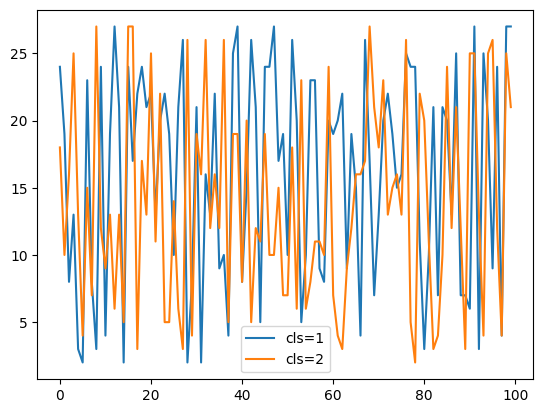

In [48]:
a,b=1,2
plt.plot(clusters[a], label=f'cls={a}')
plt.plot(clusters[b], label=f'cls={b}')
plt.legend()
plt.show()

# Old codes

In [ ]:
aligner = PairwiseAligner()
aligner.mode='global'
aligner.match_score=2.0
aligner.mismatch_score=-1.0
aligner.open_gap_score=-1.0
aligner.extend_gap_score=-0.5


s1 = 'TTTCGTCCCCCCGGACGGTGTCGGT'
s2 = 'GCTCCGACGGGGTCCGTGTTTCCCG'
s3 = 'TCTTTACGCTTCATAGCAGCAATTT'
score = aligner.align(s1, s2)
print(score.score)
print(aligner.match_score)
print(aligner.mismatch_score)
print(aligner.open_gap_score)
print(aligner.extend_gap_score)
print(score)

17.0
2.0
-1.0
-1.0
-0.5


[2 0 0 1 2 0 1 2 0 1]
[[0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1], [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0]]
[[0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0], [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0]]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0], [1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0], [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]
Inter-cluster distance: 2.0
Intra-cluster distance: 0.6


In [24]:
def Overlapped_chunk_data(N, num_chunks=4, overlap_percentage=0.3):
    """
    Parameters:
    ==============
        N (int): Size of data
        num_chunks (int) default=4: The number of chunk/windows
        overlap_percentage (float) default=0.3 (30%): Percentage of overlap between adjacent windows/chunks

    Return:
    ==============
        list((start, end)): list of index pair, start and end (exclud)
    """

    # Calculate the chunk size and the overlap size
    chunk_size = N // num_chunks
    overlap_size = int(chunk_size * overlap_percentage)

    # Split the data into chunks with overlap
    chunks = []
    for i in range(num_chunks):
        start = i * (chunk_size - overlap_size)
        end = (i + 1) * chunk_size
        if i == num_chunks - 1:
            end = N
        chunks.append((start, end+1))

    # Print the chunks
    for i, chunk in enumerate(chunks):
        print(f"Chunk {i+1}: {chunks[i]}")

    return chunks

def process_time(start: float, end: float, s=""):
    elapsed = end - start
    hours, remainder = divmod(elapsed, 3600)
    minutes, seconds = divmod(remainder, 60)
    print(f"Time taken{' for ['+s+']' if len(s)>0 else ''}: {int(hours)}h {int(minutes)}m {seconds:.2f}s")

def kmer_frequency(seq, k):
    """
    Calculate k-mer frequencies for a DNA sequence.

    Parameters:
    seq (str): DNA sequence
    k (int): k-mer size

    Returns:
    dict: k-mer frequencies
    """
    return Counter([s[i:i+k] for i in range(len(s)-k+1)])

def get_random_seq(df, clsIds, N=100):
    seq=[]
    cIDs=[]
    
    for c in clsIds:
        seq.extend(df.sequence[df.ClsID==c].sample(N).values.tolist())
        cIDs.extend([c]*N)

    return seq, cIDs

def cluster_sequences(df, num_clusters):
    cls_lbl = np.random.choice(df.ClsID.unique(), size=num_clusters)
    print("Randomly selected cluster ids=",cls_lbl)
    
    return get_random_seq(df, cls_lbl)

def calculate_distances(df, k=2, rep=100, cluster_size=10, sample_size=100):
    """
    Calculate inter-cluster and intra-cluster distances.

    Parameters:
    df: Dataset contains sequences and cluster ids
    cluster_IDs (list): unique cluster labels
    k (int): k-mer size
    rep (int): Repeat the process to compute distribution
    sample_size (int): Number of samples to pull from each cluster
    cluster_size (int): Number of clusters

    Returns:
    Intra_cluster_distance (list): list of intra cluster distance
    Inter_cluster_distance (list): list of inter cluster distance
    """

    cluster_IDs = np.random.choice(df.ClsID.unique(), size=cluster_size)

    inter_CD=[]
    intra_CD=[]

    for _ in range(rep):
        sequences, cluster_labels = get_random_seq(df, cluster_IDs, sample_size)

        # Calculate k-mer frequencies for each sequence
        freqs = [kmer_frequency(seq, k) for seq in sequences]

        # Convert frequencies to numerical representations
        num_freqs = []
        for freq in freqs:
            num_freq = [freq.get(kmer, 0) for kmer in set.union(*[set(f.keys()) for f in freqs])]
            num_freqs.append(num_freq)

        # Calculate inter-cluster distance
        inter_cluster_distance = 0
        for i in set(cluster_labels):
            cluster_freqs = [num_freqs[j] for j in range(len(cluster_labels)) if cluster_labels[j] == i]
            cluster_center = np.mean(cluster_freqs, axis=0)
            inter_cluster_distance += np.sum(pairwise_distances_argmin_min(cluster_center.reshape(-1,1), np.array(cluster_freqs).reshape(-1,1))[1])

        inter_cluster_distance /= len(set(cluster_labels))
        inter_CD.append(inter_cluster_distance)

        # Calculate intra-cluster distance
        intra_cluster_distance = 0
        for i in set(cluster_labels):
            cluster_freqs = [num_freqs[j] for j in range(len(cluster_labels)) if cluster_labels[j] == i]
            intra_cluster_distance += np.sum(pairwise_distances_argmin_min(np.mean(cluster_freqs, axis=0).reshape(-1,1), np.array(cluster_freqs).reshape(-1,1))[1])

        intra_cluster_distance /= len(sequences)
        intra_CD.append(intra_cluster_distance)

    return inter_CD, intra_CD

In [ ]:
aligner = PairwiseAligner()
aligner.mode='global'
aligner.match_score=3.0
aligner.mismatch_score=-1.0
aligner.open_gap_score=-1.0
aligner.extend_gap_score=-0.5

#s1 = "ACGTTAG"
#s2 = "ACTGTAG"
#print(aligner.score(s1, s2))

def get_Kmers(seq, K=2):
    return collections.Counter(itertools.islice(seq, i, i+K) for i in range(len(seq)-k+1))

def compute_distance(sA, sB):
    score = aligner.score(sA, sB)
    return 1/(1+np.exp2(score))

def compute_intra_SD(cid, A=1000, B=100):
    scores = []
    for _ in range(A):
        s1 = data.sequence[data.ClsID==cid].sample(B)
        s2 = data.sequence[data.ClsID==cid].sample(B)
        vis = set()
        
        for a in s1:
            for b in s2:
                if f"{a}#{b}" not in vis:
                    scores.append(compute_distance(a,b))
                    vis.add(f"{a}#{b}")
                    vis.add(f"{b}#{a}")

    print(f"Total alignments={len(scores)}")
    return np.std(scores)

def compute_inter_SID(cid, cIDs, A=1000, B=100):
    scores = []
    print(cid in cIDs)
    
    for _ in range(A):
        s1 = data.sequence[data.ClsID.isin(cIDs)].sample(B)
        s2 = data.sequence[data.ClsID==cid].sample(B)
        
        for a in s1:
            for b in s2:
                try:
                    scores.append(compute_distance(a,b))
                except Exception as e:
                    print(f"Error {e} for sequences ({a}, {b})")

    print(f"Total alignments={len(scores)}")
    return np.std(scores)



cid = tmp.ClsID.sample(1).values[0]
print(cid)
print(f"Intra SD for cluster {cid} is {compute_intra_SD(cid, A=100)}")
print(f"Inter SD for cluster {cid} is {compute_inter_SID(cid, tmp.ClsID[tmp.ClsID!=cid].values.tolist(), A=100)}")


920
Total alignments=999223
Intra SD for cluster 920 is 0.0006547996607558102
False
Total alignments=1000000
Inter SD for cluster 920 is 0.0008955627071672846


In [21]:
cluster_labels = sorted(data.ClsID.unique())
res = Overlapped_chunk_data(len(cluster_labels), num_chunks=4, overlap_percentage=0.8)
for r in res:
    print(f"sbatch runCD.slum {r[0]} {r[1]} /home/mkamruz/projects/5UTR/Data output_Aug_7_80.txt gc_content_predictions.csv")
    #print()

Chunk 1: (0, 312)
Chunk 2: (63, 623)
Chunk 3: (126, 934)
Chunk 4: (189, 1247)
sbatch runCD.slum 0 312 /home/mkamruz/projects/5UTR/Data output_Aug_7_80.txt gc_content_predictions.csv
sbatch runCD.slum 63 623 /home/mkamruz/projects/5UTR/Data output_Aug_7_80.txt gc_content_predictions.csv
sbatch runCD.slum 126 934 /home/mkamruz/projects/5UTR/Data output_Aug_7_80.txt gc_content_predictions.csv
sbatch runCD.slum 189 1247 /home/mkamruz/projects/5UTR/Data output_Aug_7_80.txt gc_content_predictions.csv


In [ ]:
k = 2
num_clusters = 10
num_sample = 1000
num_rep = 100

#st = timeit.default_timer()
#sequences, cluster_labels = cluster_sequences(sample_df, num_clusters)
#et = timeit.default_timer()
#process_time(st, et, "cluster_sequences")

#print(len(sequences), len(cluster_labels))

st = timeit.default_timer()
inter_cluster_distance, intra_cluster_distance = calculate_distances(sample_df, k, num_rep, num_clusters, num_sample)
et = timeit.default_timer()
process_time(st, et, "calculate_distances")

#print("Inter-cluster distance:", inter_cluster_distance)
#print("Intra-cluster distance:", intra_cluster_distance)

In [78]:
# Any sequence belongs to multiple cluster?
tmp = data.groupby('seq_index')['ClsID'].apply(lambda x: x.nunique()).reset_index()
tmp.columns=['seq_index', 'total_clusters']
print(tmp.total_clusters.min(), tmp.total_clusters.max())
del tmp

1 1


In [ ]:
def compute_out_cls_stat(df):
    if len(df)==0: return

    low = int(df['predictions'].min())
    high = int(df['predictions'].max())
    ClsID=[]
    Count=[]
    predictions_std_out=[]
    gc_content_std_out=[]
    predictions_std=[]
    gc_content_std=[]
    freq = {}
    for i in range(low, high+1):
        freq[f"{i}"]=[]
        freq[f"out_{i}"]=[]

    tmp = df.groupby('ClsID')['predictions'].apply(lambda x: len(x)).reset_index()
    tmp = tmp[tmp.predictions>1]

    print(f'Total clusters to process={tmp.ClsID.nunique()}')

    for cid in tmp.ClsID.unique():
        ClsID.append(cid)
        Count.append(df[df.ClsID==cid].shape[0])
        predictions_std_out.append(np.std(df['predictions'][df.ClsID!=cid]))
        gc_content_std_out.append(np.std(df['gc_content'][df.ClsID!=cid]))
        predictions_std.append(np.std(df['predictions'][df.ClsID==cid]))
        gc_content_std.append(np.std(df['gc_content'][df.ClsID==cid]))
        
        '''f = Counter(df['predictions'][df.ClsID==cid].values)
        for k in f:
            freq[f"{k}"].append(f[k])

        f = Counter(df['predictions'][df.ClsID!=cid].values)
        for k in f:
            freq[f"out_{k}"].append(f[k])'''

    d = {'ClsID':ClsID, 
        'predictions_std':predictions_std, 
        'predictions_std_out':predictions_std_out, 
        'gc_content_std':gc_content_std, 
        'gc_content_std_out':gc_content_std_out, 
        'Count':Count}
    
    return pd.DataFrame(d)

'''df_agg = data.groupby('ClsID').agg({
    'predictions': ['std'],#['min', 'mean', 'median', 'std', 'max'],
    'gc_content': ['std', 'count'] #['min', 'mean', 'median', 'std', 'max', 'count']
}).reset_index()
df_agg.columns = df_agg.columns.map('_'.join).str.strip('|')
df_agg.rename(columns={
    'gc_content_count': 'Count',
    'ClsID_':'ClsID'
}, inplace=True)
display(df_agg.head())'''

df_agg= compute_out_cls_stat(data)
df_agg.to_csv(os.path.join(data_path, "whole_cluster_std_inc_exc.csv"), index=False)
display(df_agg.head())

Total clusters to process=21741


,ClsID,predictions_std,predictions_std_out,gc_content_std,gc_content_std_out,Count
0,1,3.070038,3.078177,0.044123,0.099996,2647
1,2,2.784153,3.079508,0.047708,0.100165,49882
2,3,2.671473,3.078447,0.040773,0.099973,4767
3,4,3.454637,3.078170,0.038717,0.099967,1487
4,5,2.682835,3.078288,0.042934,0.099997,1886


In [24]:
df_agg = pd.read_csv(os.path.join(data_path, "whole_cluster_std_inc_exc.csv"))
print(f"Total clusters to process={df_agg.ClsID.nunique()}")
df_agg.head()

Total clusters to process=21741


,ClsID,predictions_std,predictions_std_out,gc_content_std,gc_content_std_out,Count
0,1,3.070038,3.078177,0.044123,0.099996,2647
1,2,2.784153,3.079508,0.047708,0.100165,49882
2,3,2.671473,3.078447,0.040773,0.099973,4767
3,4,3.454637,3.078170,0.038717,0.099967,1487
4,5,2.682835,3.078288,0.042934,0.099997,1886


<Figure size 2000x1200 with 0 Axes>

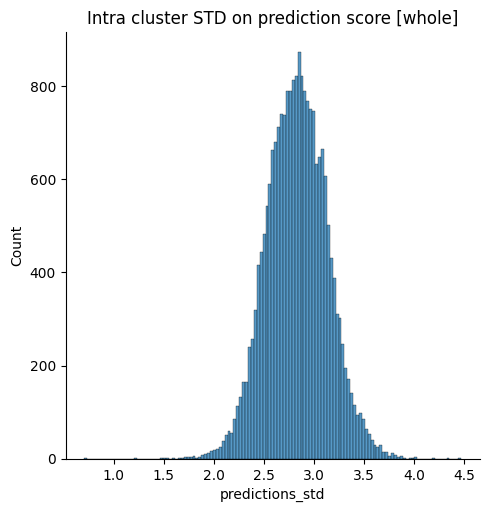

<Figure size 2000x1200 with 0 Axes>

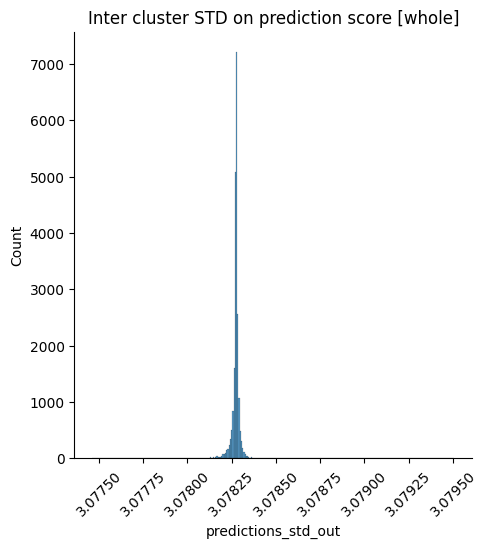

In [25]:
plt.figure(figsize=(20,12))
sns.displot(df_agg.predictions_std, kind='hist')
plt.title('Intra cluster STD on prediction score [whole]')
plt.show()

plt.figure(figsize=(20,12))
sns.displot(df_agg.predictions_std_out, kind='hist')
plt.title('Inter cluster STD on prediction score [whole]')
plt.xticks(rotation=45)
plt.show()

In [27]:
l = [len(x) for x in data.sequence]
min(l), max(l)

(25, 25)

In [79]:
df_agg = data.groupby('ClsID').agg({
    'predictions': ['min', 'mean', 'median', 'std', 'max'],
    'gc_content': ['min', 'mean', 'median', 'std', 'max', 'count']
}).reset_index()
df_agg.columns = df_agg.columns.map('_'.join).str.strip('|')
df_agg.rename(columns={
    'gc_content_count': 'Count',
    'ClsID_':'ClsID'
}, inplace=True)
df_agg.head()

,ClsID,predictions_min,predictions_mean,predictions_median,predictions_std,predictions_max,gc_content_min,gc_content_mean,gc_content_median,gc_content_std,gc_content_max,Count
0,1,5,18.060446,18.0,3.070618,26,0.32,0.441390,0.44,0.044131,0.56,2647
1,2,5,20.024638,20.0,2.784181,27,0.32,0.473496,0.48,0.047709,0.64,49882
2,3,8,19.874554,20.0,2.671754,27,0.28,0.377000,0.36,0.040777,0.48,4767
3,4,5,18.226631,18.0,3.455799,27,0.60,0.698319,0.68,0.038730,0.80,1487
4,5,10,20.909862,21.0,2.683546,27,0.40,0.507635,0.52,0.042945,0.64,1886


In [80]:
print("Total clusters=",df_agg.ClsID.nunique())
print("Total singleton cluster=",df_agg.ClsID[df_agg.Count==1].shape[0])
print("Total non-singleton cluster=",df_agg.ClsID.nunique() - df_agg.ClsID[df_agg.Count==1].shape[0])

Total clusters= 181136
Total singleton cluster= 159395
Total non-singleton cluster= 21741


In [81]:
df_cnt = df_agg[df_agg.Count>1]
print(df_cnt.shape)
df_cnt.head()

(21741, 12)


,ClsID,predictions_min,predictions_mean,predictions_median,predictions_std,predictions_max,gc_content_min,gc_content_mean,gc_content_median,gc_content_std,gc_content_max,Count
0,1,5,18.060446,18.0,3.070618,26,0.32,0.441390,0.44,0.044131,0.56,2647
1,2,5,20.024638,20.0,2.784181,27,0.32,0.473496,0.48,0.047709,0.64,49882
2,3,8,19.874554,20.0,2.671754,27,0.28,0.377000,0.36,0.040777,0.48,4767
3,4,5,18.226631,18.0,3.455799,27,0.60,0.698319,0.68,0.038730,0.80,1487
4,5,10,20.909862,21.0,2.683546,27,0.40,0.507635,0.52,0.042945,0.64,1886


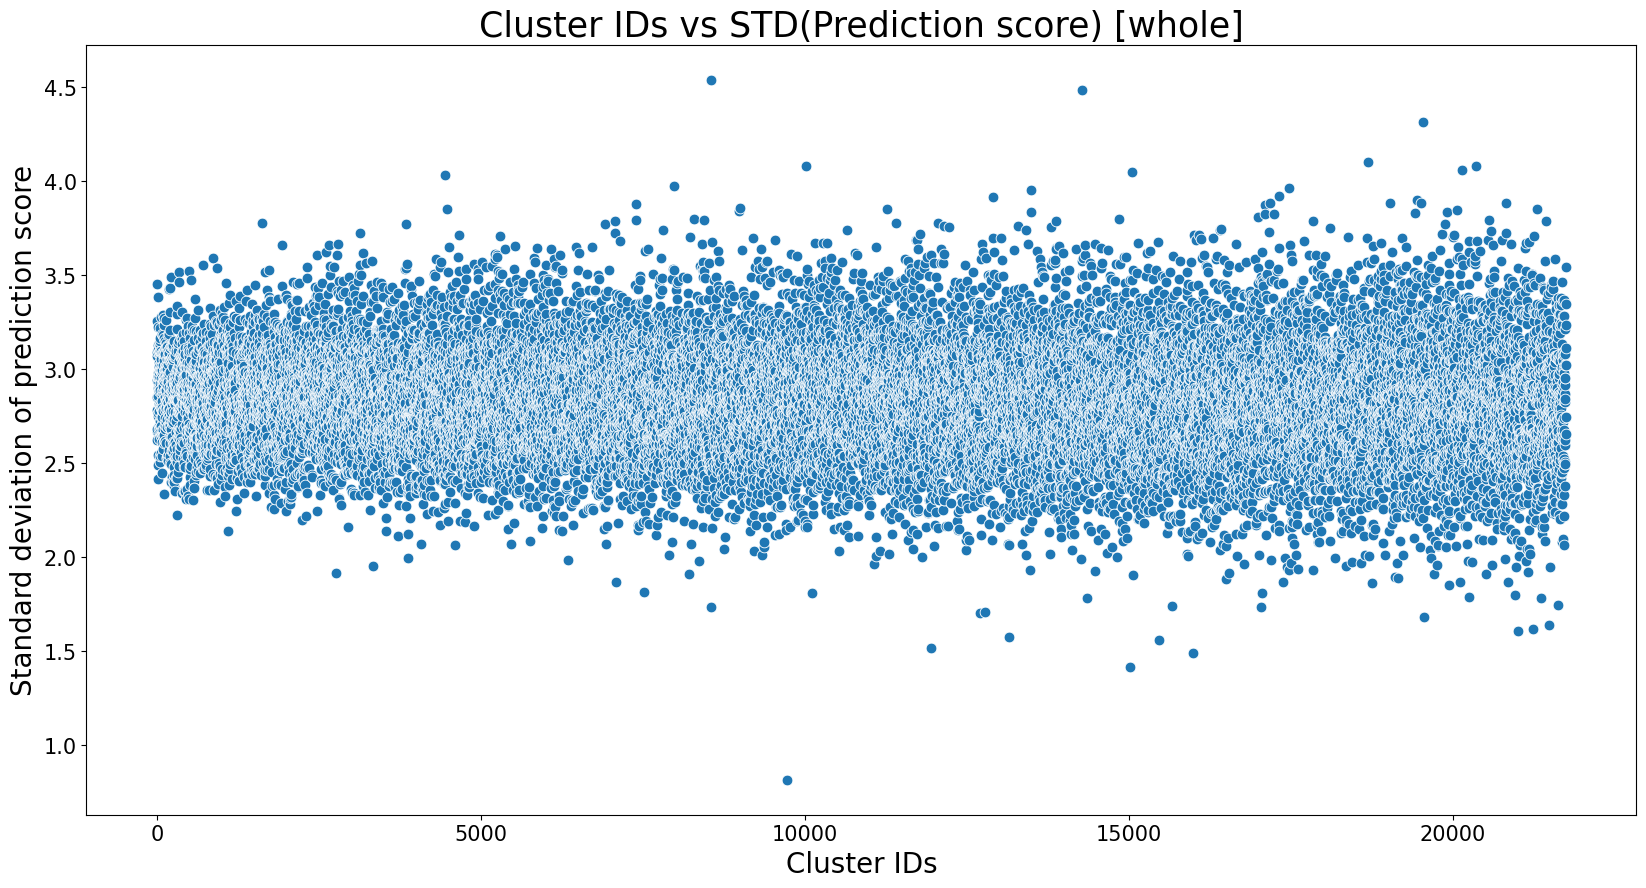

In [84]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=df_cnt.ClsID, y=df_cnt.predictions_std, s=60)
plt.xlabel('Cluster IDs', fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Standard deviation of prediction score', fontsize=20)
plt.yticks(fontsize=15)
plt.title('Cluster IDs vs STD(Prediction score) [whole]', fontsize=25)
plt.show()

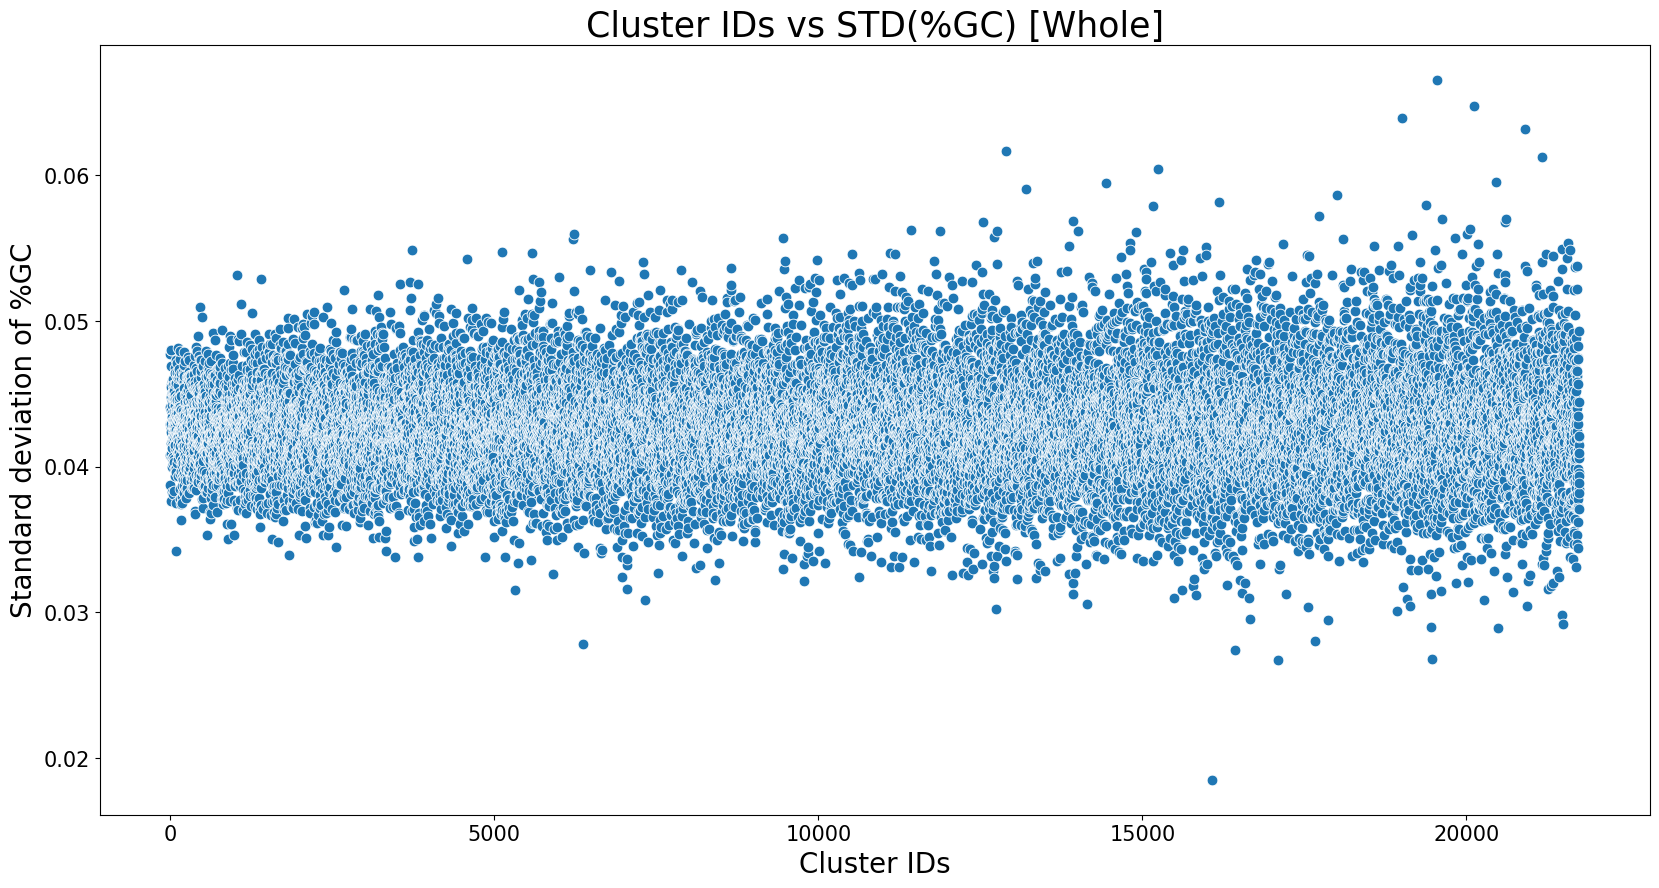

In [85]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=df_cnt.ClsID, y=df_cnt.gc_content_std, s=60)
plt.xlabel('Cluster IDs', fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Standard deviation of %GC', fontsize=20)
plt.yticks(fontsize=15)
plt.title('Cluster IDs vs STD(%GC) [Whole]', fontsize=25)
plt.show()

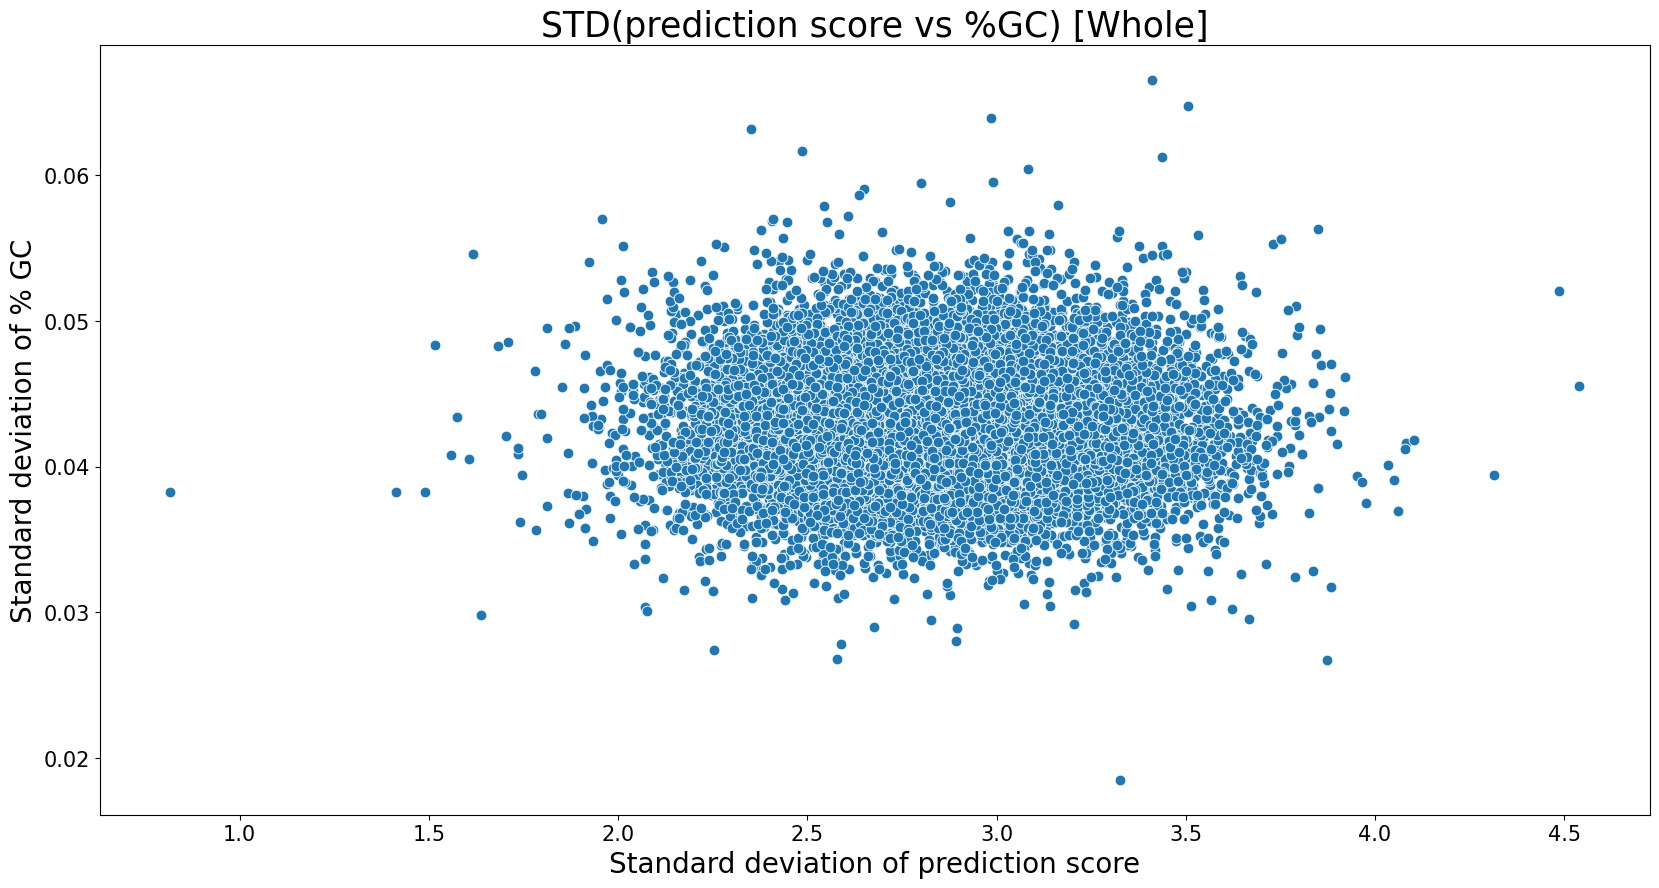

In [86]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=df_cnt.predictions_std, y=df_cnt.gc_content_std, s=60)
plt.xlabel('Standard deviation of prediction score', fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Standard deviation of % GC', fontsize=20)
plt.yticks(fontsize=15)
plt.title('STD(prediction score vs %GC) [Whole]', fontsize=25)
plt.show()

# Other